In [2]:
# Tracking problems for Linear Quadratic Regulators
%matplotlib notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.animation as animation
import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)


class Quadrotor2D:
    """
    This class describes a 2D quadrotor model 
    """
    
    def __init__(self):
    
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define radius and masses
        self.r = 0.15
        self.m = 5.0
        
        # Define constant A, B for system dynamic equation
        self.A = np.array([[1.,0.,0.,self.dt,0.,0.],[0.,1.,0.,0.,self.dt,0.],[0.,0.,1.,0.,0.,self.dt],[0.,0.,-self.dt*self.g,1.,0.,0.],
                   [0.,0.,0.,0.,1.,0.],[0.,0.,0.,0.,0.,1.]])
        self.B = np.array([0.,0.,0.,0.,0.,0.,0.,0.,self.dt/self.m,0.,0,self.dt/(self.m*self.r**2)])
        self.B = self.B.reshape(6,2)
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the 2d quadrotor syste as a numpy array (x,y,theta,v_x,v_y,omega)
        u: thrust forces as a numpy array (u1,u2)
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        y = z[1]
        th = z[2]
        v_x = z[3]
        v_y = z[4]
        om = z[5]
#         x_next = x + self.dt * v_x + 0.5 * self.dt**2 * ((u[0]* np.sin(th))/self.m)
#         y_next = y + self.dt * v_y + 0.5 * self.dt**2 * (-self.g + (u[0]*np.cos(th))/self.m)
#         th_next = th + self.dt * om + 0.5 * self.dt**2 * u[1]/(self.m*self.r**2)
        x_next = x + self.dt * v_x 
        y_next = y + self.dt * v_y 
        th_next = th + self.dt * om 
        v_x_next = v_x - self.dt * ((u[0]* np.sin(th))/self.m)
        v_y_next = v_y + self.dt * (-self.g + (u[0]*np.cos(th))/self.m)
        w_next = om + self.dt * u[1]/(self.m*self.r**2)
        z = np.array([x_next,y_next,th_next,v_x_next,v_y_next,w_next])
        return z
    
    def simulate(self, z0, K, uff, horizon_length):
        """
        This function simulates the quadrotor of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the 2D quadrotor as a numpy array (x,y,theta,v_x,v_y,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[6x(time_horizon+1)] and u[2,time_horizon] containing the time evolution of states and controls
        """
        uoff = np.array([[self.g * self.m, 0.]]) # To simulate original quadrotor dynamics remember to add u0 = [mg 0]!
        z=np.empty([6, horizon_length+1])
        z[:,0] = z0
        u=np.empty([2,horizon_length])
        for i in range(horizon_length):
            u[:,i] = uoff + K[i].dot(z[:,i]) + uff[i]
#             u[:,i] = uoff + K[i].dot(z[:,i]) 
#             u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u

    def LQ_simulate(self, z0, z_des, K, uff, horizon_length, feedforward):
   
        uoff = np.array([[self.g * self.m, 0.]]) # To simulate original quadrotor dynamics remember to add u0 = [mg 0]!
        z=np.empty([6, horizon_length+1])
        z[:,0] = z0
        u=np.empty([2,horizon_length])
        for i in range(horizon_length):
            if feedforward:
                alpha = 0.7
                u[:,i] = uoff + K[i].dot((z[:,i]-z_des[:,i])) + alpha*uff[i] #note that the computed feedforward need to be scaled down
            else:
                u[:,i] = uoff + K[i].dot((z[:,i]-z_des[:,i]))
            z[:,i+1] = self.A.dot(z[:,i]) + self.B.dot(u[:,i]) #here use approximation system dynamics to simulate
#             z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u
    
def solve_ricatti_equations(A,B,Q,R,horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min sum(xQx + uRu) + xQx subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from 0 to N
    K: list of numpy arrays containing Kn from 0 to N-1
    """
    P = [] #will contain the list of Ps from N to 0
    K = [] #will contain the list of Ks from N-1 to 0

    P.append(Q) #PN
    
    for i in range(horizon_length):
        Knew = -1.0 * np.linalg.inv(B.transpose().dot(P[i]).dot(B) + R).dot(B.transpose()).dot(P[i]).dot(A)
        Pnew = Q + A.transpose().dot(P[i]).dot(A) + A.transpose().dot(P[i]).dot(B).dot(Knew)
        K.append(Knew)
        P.append(Pnew)
    
    # since we went backward we return reverted lists
    return P[::-1],K[::-1]


def check_controllability(A,B):
    """
    This function check  the controllabilitystate for system
    c=[B AB A^2B A^3B A^4B A^5B]
    """
    c=np.concatenate([B, np.dot(A, B), np.dot(A, A).dot(B),np.dot(A, A.dot(A)).dot(B), np.dot(A.dot(A), A.dot(A)).dot(B), np.dot(A.dot(A), A.dot(A).dot(A)).dot(B)], axis=1)
    R=np.linalg.matrix_rank(c)
    print('rank is',R)
    if R < np.linalg.matrix_rank(A):
        print('is not controllable')
    else:print('is controllable')

def animate_2dquadrotor(z, dt):
    """
    This function makes an animation showing the behavior of a 2d quadrotor
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotz = z[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,6.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-10,10], ylim=[-8,8])
    ax.grid()
    
    list_of_lines = []
    
    #create the simplified quadrotor
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'ro', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'go', lw=2)
    list_of_lines.append(line)

    
    quad_radius = 0.2
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_quad1 = plotz[0,i] + np.cos(plotz[3,i])
        y_quad1 = plotz[1,i] - np.sin(plotz[3,i])
        x_quad2 = plotz[0,i] - np.cos(plotz[3,i])
        y_quad2 = plotz[1,i] + np.sin(plotz[3,i])
        
               
        list_of_lines[0].set_data([x_quad1, x_quad2], [y_quad1, y_quad2])
        list_of_lines[1].set_data([x_quad1,x_quad1], [y_quad1,y_quad1])
        list_of_lines[2].set_data([x_quad2, x_quad2], [y_quad2, y_quad2])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotz[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))
        
def plot_results(z,u,K,animate):
    """
    This function plots the results. It displays (plane & angular) positions and velocities of the quadrotorvfor all states.
    Then it displays the evolution of two thrusts as control inputs. 
    It's optional to display the feedback control gains K at each step when applying LQR controllers.
    Finally it shows an animation of the quadrotor's motions.
    """
    
    t = np.linspace(0,quadrotor.dt*(horizon_length),horizon_length+1)
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(t,z[0,:])
    plt.ylabel('horizontal position x')
    plt.title('Position')
    plt.subplot(3,1,2)
    plt.plot(t,z[1,:])
    plt.ylabel('vertical position y')
    plt.subplot(3,1,3)
    plt.plot(t,z[2,:])
    plt.ylabel('angular position theta')
    plt.xlabel('Time')
   

    plt.figure() 
    plt.subplot(3,1,1)
    plt.plot(t,z[3,:])
    plt.ylabel('$v_x$')
    plt.title('Velocity')
    plt.subplot(3,1,2)
    plt.plot(t,z[4,:])
    plt.ylabel('$v_y$')
    plt.subplot(3,1,3)
    plt.plot(t,z[5,:])
    plt.ylabel(r'$\omega$')
    plt.xlabel('Time')

    
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t[:-1],u[0,:])
    plt.ylabel('$u_1$')
    plt.title('Control thrusts')
    plt.subplot(2,1,2)
    plt.plot(t[:-1],u[1,:])
    plt.ylabel('$u_2$')
    plt.xlabel('Time')
   

    # we can plot the computed gain
    # Note that in this case K is a 2 by 6 matrix with 12 elements
    K = np.array(K)         
    plt.figure(figsize=[8.5,4.5])
    plt.subplot(1,2,1)
    plt.plot(K[:,0],'-o', markersize=6)
    plt.legend(["K00","K01","K02","K03","K04","K05"],fontsize = 6,frameon = False,loc ='best')
    plt.ylabel('K1')
    plt.xlabel('Time')
    plt.title('Feedback gains')
    plt.subplot(1,2,2)
    plt.plot(K[:,1],'-o', markersize=6)
    plt.legend(["K10","K11","K12","K13","K14","K15"],fontsize = 6,frameon = False,loc ='best')
    plt.ylabel('K2')
    plt.xlabel('Time')
    plt.title('Feedback gains')
    
    if animate:
        animate_2dquadrotor(z, quadrotor.dt)

rank is 6
is controllable


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAcbG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAO1mWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0ALZS34I
Wx3uYA5RDRtbShrl92onXtCOF3soqrWRis0abaOtmJtHCBZqqydTegpXowDXBG6blu81O3T5l9d+
t9O2cBHx8RAWRZPXksvOWSgUzCWmZIAB1taVug4ldayhBH9vBrDcE9LbGBZnIQ0NiMYUTXQq+xcu
Trrs1mPTdYHDLPC4axmY2MOy3X3pdelPc5STqA9zpPJJVWrIeZ+VAYJICDb3OOI1X9twcDcAmGhQ
cmu+PiyI1OrUU8TUEf/TSllvmI//xpBPK/sgi8az0THEqKYxygqcc74gOpjZtMsC5ue9zkPk7rJa
+7TKaK2MsiieEgie+3XeOZiLJVgEyaFAFyZ23dRccYbRT+f/Jup/CSQ2rziTGL/kG5lzCnyH9Kak
Rc4/JvIzbI0v6LOX86AEZWIncv4oZIcxTfCr5ToUVKHu9J0RZ/PprrTGtJV18HGmMUQsBnFwAMfT
sOIZnQoUHRiOeGXy3ekgrNJgdiWO5/7XstxyK8TpEEasDj1sUiE2RhXMcm+f1W7aWOrFI//0d1Bg
ZGT3HV3RH+r49vuMOQ4D5OQ0F8rgciOQ1LB47/WMN4IyaJy6Qg/LL4HKz8FSH2ixtlIMRHmdo+6s
uXRzvy5JT6NDoMNukEgAAAMAXY3nlGwZRogYywcjffzE8QeM+EdywgD9OUQCqABjGr8amiKLYqq3
5SJu+LXoy4dshmzg6XmmvNxGiZdpk1+g1Sc29i03C9Ol4Tv2//Bo/AxVvynWVB+rWFX4y42M1kU0
GW56VDbkUeLugVSsj4wuomv/xl+brcMZNc+aSWE7X6EhnI6Dtqs6fuH3IADHM5h7w8ZMCLlSAIUu
5e41vx31f0h7E17aPmVbEuGFerb8A0DKf+Kua1X5xIlBbEVBUlsZ0MPFMB7GZMup/mnLGkxXzrSk
VoqH3AAFVxT9dLshW5RrRWGGUxZe3s+d7gnC1G6/rmleNdqRZOOayBFpYnXwBUtQYwJbeTWNkVfQ
GV1cdgDeWwZWcl2rjwS90c4ZkupByjtc8HB04+4mN3XyrgK5B4K5EtVpDC67ktENZ9yP7//moC2o
BwM3lMfieVYw7Ma1SJ2lWjoqZP9De3cnIDtADNQJWJpQRZCWrPknJYfbCOjbUoTkEiw/+9le+lZu
M8si5fE5jZH4hedsHP0ksNgEGzivOV08Wq+Ocik/9N2INIZmFxXn/cgfXACq7NuL3XEbWG/lGoyM
9vjxZP6s4OD+pP4RndPaDvIeJEc5EeyHAAAFw/x8D8AGKlfeLpCR8UeikHrXZsqhwr8wiLGQ1hMq
WdtBTODVQd2bqnMmGY+VLHH/ZU/1e0mWu8YsLTcqAfr6/hogFdG8k2Gwk/OT1B8eliXHVLcD3gKR
fqouYEDUKQhrLTTDCLZBT7+7UTqkPZIC+D8oDfzY7mKtdyRVgO8juvhWv//AAAYBffL2pfz06JTH
wuOKUNN1z3oRa7esud/I79uaPQWVYrg/ANMgBqLFhCF3sp5mWnJX0dZhbMBjf3KMtVUISvf/BE/y
+I7sOJ3uy8hJOuOZaLVsyb1LE+FXLF615FdMrqt1YplLcJVrIG4LGpy9jrP/v/sb0G/Y4m/OiC3m
j+5HdB+n7S4Rz8MooYVUpBZkUOwdbq8V4VViHi1LH2tAQIvfbEDmiP4jLWWn2BbSB4POlhlorCfU
PfugYi7VHD3mDIB4gcxxc1pq/8ndpxIFFagerPvVck7vXDMM/zPtlFvxTq8nDiA6AIi9lvWbs3NQ
I7L+1R89CYwl6o5Kcm8MpK3SrRQsjkUXkKvIrEcr8s4u+zZR/qWfYLipaChApBeC0dCp+GPDgco+
Yx7O0nuZVSGYCuUSPAUgmcIdOz/QRmKnYk/0F6Nt3reg1vJcwLIH3ZWgpSy4z5sD57BLUqes6GCi
PWIhsI3mfoQBkr7RXhQxqo4+X+qgV6qUuNbUr3N5/C1ofVqbAAADAAEcRRCH/uwEm8/A8CyG8ypT
TkNTYJZQtTvSn3pEf+J1sgDXUC5vZtNUNUkPkM0fVIsXHKsb61JUtjKqrc1JluDCmXykvtrhPgMs
qqcVsM8PXj0RD5Ve/VyxrnTLLkUi2gob5UdZmrbXMl1IKx3F0EmCb8gJy1nKpIoVExstWQe090uF
+Ace8CUg1IahbGreWZf+WdQn//9gADOfpXIV1KsAsrI7eSfhBPGxoFrMwTvyaIgZLw1wqixhMxrR
X4weU0y/j6HWk5tIqz/vz+9qWsjywZNKyfFkS5/IrFxmhIW0TH3gmnA14xs98ndUELQarRL8qkDH
LD6gEzaR3eNr1SdfeJHtLqqNK33UOGJQohsfs+VMmSrf21ZKjFUDy5yILJOwUVKNl5G10EuYgJlF
FP5vzX84Ld1hdgZll0S1r4v+Jj0KW79QLZxEXqUJMIjNQzwDmdgfvIM7ydhGqAC+wrjruf+F5AW4
GMH+ThW4nz+N9C844aDf81dEll7aP63VuhvCyv109iIKXGCV2LS8N39lF8yVtt5d//+IBzh5kANY
5UoXeZZVYBwM6atFgkZkALX7zvUfnsAHrGq9Z/QnyIF+YdXLsUq+YLTkPuGB7gzAv4ULCkI4336c
ovpZW9yC/dvrx9+57zwErJDZ/1SZMxYVtAAal+K1WkwIu3p6WQ66ZCjB/T2ai/zwdgWNIm1tStSI
XoBrG6u57X7dDLPCWkuvB4ElibZTSNFM9CByReAmW9Na0ucfLqV1GjFX9N16rVw6yZWkr0C1vkzZ
rCQutvjh6Iq3FhfmQBT61tMDbh2Atg4yEVpFChITt5UsCkdgOMYQP196L7pBURai/Kj//9IEgq5/
tRScrR3/yOzB3AL/1gAKP

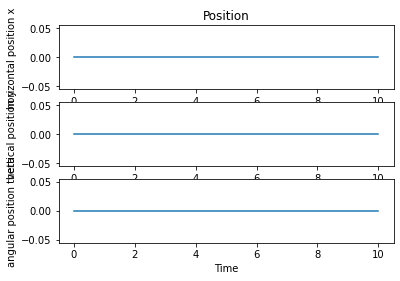

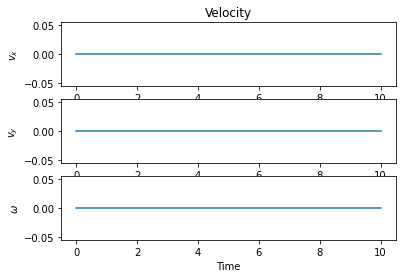

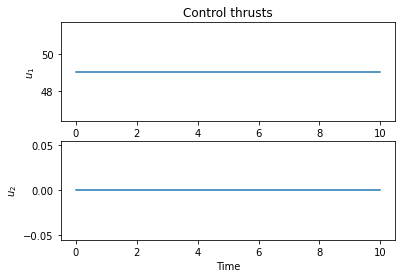

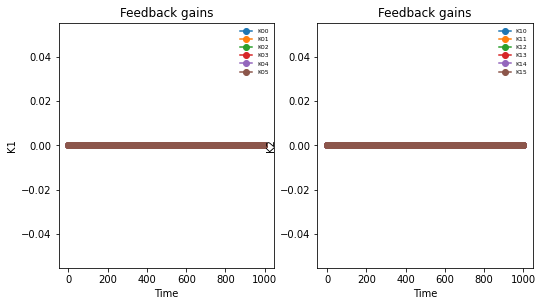

In [3]:
# When do nothing the quadrotor can keep stable at the fixed point 

# create a 2dquadrotor
quadrotor = Quadrotor2D()
check_controllability(quadrotor.A, quadrotor.B)

# we simulate the 2dqudrotor when do nothing
z0 = np.array([0,0,0,0.,0.,0])
horizon_length = 1000
# useless controller
k = np.array([[0,0,0,0.,0.,0],[0,0,0,0.,0.,0]])
uf = np.array([0.,0.])
K = []
uff = []
for i in range(horizon_length):
    K.append(k)
    uff.append(uf)

z,u = quadrotor.simulate(z0, K, uff, horizon_length)
plot_results(z, u, K, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA73m1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAOc2WI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrh/uMdsT2wAAAK4AFvpH8E
LY2vMAnVN747X9YU6COah5mpiQjMc1aKt2JTVn/jU/u1ZAs1VZOpvPka1f5PwjdNy3eZU4s3lgJv
W+nbNwTQ+IgLIsnryWXnLJQKYxLTJkABYLl6UryJ7vJ5M55bMRDcFGBQU/J6YIQV2kXQX7PC+yzK
WZU1IaM5uosQWfaUTq/2BVEkx948onFvp1jCcoKwI3LzTwaFO0uWqbQ76ndp9nPSrAbSpSFmbiri
VY5/WUUpmSIaj2Fmw7sXVjXz5LrxtMLDJYrHh1XaZwQWpARfZM77xxHcSPz4aGJopNQNNzpjTrxi
a2+FGH2mVg1KE1gRH/kB2ZqDlBBtFx+GMc7D/bWpn1C0QgHoctnya33m0i6YVj6/SBlQ4Y8n7/Gy
dCuJP7lgblGAL/zSgba0ikWY9FiMpRa7/5NNvaJV8X0ELIV/tneX1LMhqgJPythXuWs1sS0wJ9Cx
LVPmeWBreFnvq+EeUBtAGZ0KI7PsGQvHroDhlZyknWnRbHP/s5C3keUNrZyJeNMVDBiRCbIwrpx5
CHabq9bZ7SoJzikpk9x1d0SA8/7vW2DDbTLbpmCL5ZyIT6verpNsxjFUrffC/38He8+zawoEAXQp
bFgPJ2BKfzw+DwqNUpcWrGN60wAXE/OJQhv6dppzNHc/ettMWzR6OL5ZtoZxkBof3i+w5IUNbD1u
+dYxuJaXp2M/bIipBqNULHCXULKOXU7K13eQPBrJSaoHSLE7yx3X8Zr6COmjvfkwsDb6Nt77+fyJ
FEJdwQLtdcmsHBHpuvLtcfZ4snKCEpPuMxDP8BgmDEZRjtkOOS4q8bSKtDEy+tqtYSBqAAADASyk
sRCY9OBk6mrOvaYyZEL7Li6+Wpd7timVmZQPUPHr+quPEneAN8IRXKNsyABu5flnhrX+ogjMLl7A
Y40Or0/1QNVprKxHX32ga/ffJeaG0efc6SmZHietdRelVNLOTVBPPwttElUO3FstzyI6w3R/MgUC
KtPKyKaDLdDFvrQS4B3yeS8Ld+hdPnflXWqs60I/6b5uKRfGyFlNSOhPtZQyBKyMX6ZUoUW7drE1
hcqQAwMKh7oLDdaaHIVmJm/26YFWANsy3OsMNIsYgcC3HeYdBAZ0z6Tx837f/t4LA1ddohkd/CUw
z+zvUoUT6CC1nMlUkD0c2d31IiLLYAAAAwGFMgu1ZisrHDgzlYxIBDzO3gewOXc8KAGjkbpTS9E3
OohhdibcxLrh8stBKmhMtnUxcEYW/iDY1HvJSLsxxOLb/TkZYxsyTEuZDnPvZcWek3ycERVR1LK3
aMDjPJnuyQgGp++Lq6w+yd/zwBpaiA1Mp1MXvZTWXVKXou0A9AOpvl9zbqMmf99wMEnny5WVqOtq
xMUvBFoZchUCkwnRcpNtxJ5+6Cb9RHnActZJU/vojpmFIYZcNBvV43Ou3GR6rdc1QIYndpUdvX7R
ltGf5XpO9EafpAeymkhmuZ2LBZLtvLmlp/8OZZgdxk/Hl1cLLAhbSVFWzSdkw+1V9LZ/jyXCFY+w
ADIx35pCE7YOHbDbZLoAAEf7gSgc9St63T1Iwav9mp4XEGuZLlY/iQU2CY0nMy+jJ5bZWqlZxw90
19KnMhKuuaLBipu12izNZ3qHDm2cHGwkG2+pBk9SBMKCpSFrQihwkHpIZbW+cX1EpWqd3ntDrTBT
KT/prEf+29COcIMoqpOaVbhnm6HyygggKy/+ZIAygSvYlHdICVMxMGuAS3rcOXqu3N7zfBydJr4C
GUwiZLrVtLfSTGrJy48sLvD0fUo7W7ERqpQzPXoqxVZS50/PmP+/IukjeczuxH9PNm79fTB5Yf9/
fxZeDwmfvq5xv6tmzWn7PVtzKl4rwEoCKG9n+8dmLfdDWaQGEiL92AeiDAix0Y0aMxhYwUNwFFuM
tUltRKJ9IHjW0JE+NsVpYtv56yGRdwyeWB7kE+oAwMGhLbYzXYz41uMt00txEPMIJq3sKlvj+Dqw
pzsGMzcgCQhZLLG2+Y+YEJLd30DrkVhYQZc1Iw0fpkcEoVL+udJtFyiTXal5ZvpYYOK4b/Jyuw9a
gzMT93ScmZwwTtL//SALXt2dda5+1PDkzjukRklicjFnoAAHafvrvy9WE1UfH6Tdc+5QcZ6xhuzh
rw4kISrSr7r1mobEfAykDyDzVNt4X8/O5f3Xaw5YmCugc52uZr0FO21kKkEcOGdNTKAA+SVcxYc7
+GLwZjSNgxE9cIhXejDX1Mzye/ff21ZJUlBtRzMzD1nNk/xNbEU4KWmCb4KjFCEohO9ShK9CMcl0
UuC3A0MaUTzH6gWziIvUoSYRBhcm2cgQ9NoM7ydhGqADU+WECj4KmnFcwH1lKc2d8zArIh+jC2Iy
U//MijwrxjknDlJld9k3WHnjC8gviuQalqW2Q4b18qcINDggL//6gFsNs16w82x3EQhBATs97x0K
KIAAALn70Lcb61dMHW5OcV0Y4wOTJWf6MKnO4YTAuFJj3AvlrzsnzGi5HXmmXQFPOLqHag1VjOL4
58MeqN6AAoB2ZrdefS4AB5yLquyAiaSvGMEQwBSfzqQPZoF/PB2BY0QFDG5Gzc3cWq6XNxKV4TwH
LLyqVSUYbDjs8Jjq3xLEJycIAj2ZwQSrkOT5XUaMVf03XqtXDrLc2jYU4C/b8T1oEi98cPQ47AtN
rQ+xHWNnHc04EapU5cJm4uZmbypYFI6DOvRqzVVxnkukFRFqN6of//rAfAGlmJtQW/seWFWba7HX
XMAJDCAKvE0U4ZYyXWraY/zHEvMaoNew4Ux9gdqp26fI/sbUb2BO98PBU5ensb4RKEcoEoGfwCAs
R7ca50ekJBpGqNSPU6R4S

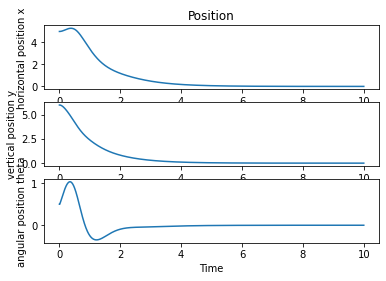

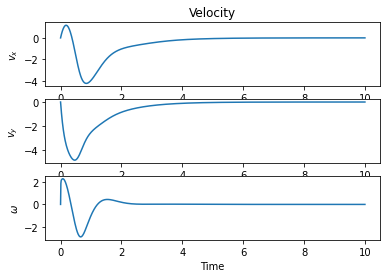

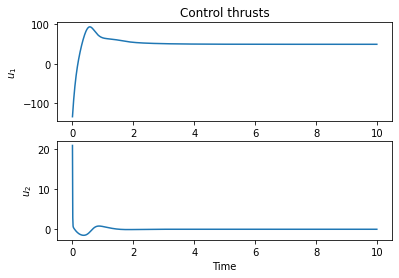

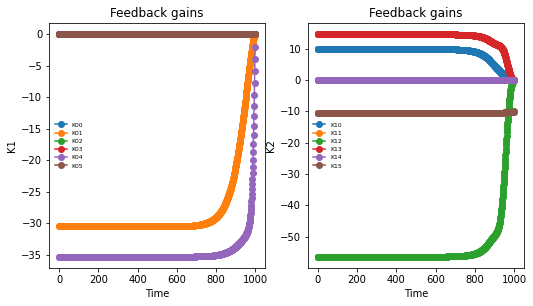

In [4]:
## First we use LQR to stabilize the quadrotor system around the fixed poiont(all zeroes)

#initial state
z0_1 = np.array([5, 6, 0.5, 0.,0.,0])
horizon_length = 1000

Q=100*np.eye(6)
R=0.1*np.eye(2)

P1,K1 = solve_ricatti_equations(quadrotor.A, quadrotor.B, Q, R, horizon_length)

# here we need to add the feedfordward command uff computed due to the change of variables
# in this case since the stabilized point z0 is a zero vector
uff1 = []
for i in range(horizon_length):
    uff1.append(-K1[i].dot(np.array([0,0,0,0.,0.,0]))) 
    
# def feedforward_controller(z,i):
#     u = K1[i].dot(z) + uff[i] 
#     return u

z_1,u_1 = quadrotor.simulate(z0_1, K1, uff1, horizon_length)
plot_results(z_1,u_1,K1,animate=True)

In [5]:
def animate_2Dquadrotor_2(z,z_des,dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    zdes = np.hstack((z_des,(z_des[:,-1]).reshape(6,1)))
    plotz = z[:,::steps]
    plotzd = zdes[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,6.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-2,30], ylim=[-6,8])
    ax.grid()
    
    list_of_lines = []
    
    #create the quadrotor
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'ro', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'go', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'bo', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'b', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'C1o', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'C1--', lw=2)
    list_of_lines.append(line)
    
#     quad_radius = 0.2
    x_data,y_data = [],[]
    x_goal,y_goal = [],[]
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_quad1 = plotz[0,i] + np.cos(plotz[3,i])
        y_quad1 = plotz[1,i] + np.sin(plotz[3,i])
        x_quad2 = plotz[0,i] - np.cos(plotz[3,i])
        y_quad2 = plotz[1,i] - np.sin(plotz[3,i])
        x_com = plotz[0,i]
        y_com = plotz[1,i]
        
        x_data.append(x_com)
        y_data.append(y_com)
        x_goal.append(plotzd[0,i])
        y_goal.append(plotzd[1,i])
               
        list_of_lines[0].set_data([x_quad1, x_quad2], [y_quad1, y_quad2])
        list_of_lines[1].set_data([x_quad1,x_quad1], [y_quad1,y_quad1])
        list_of_lines[2].set_data([x_quad2, x_quad2], [y_quad2, y_quad2])
        list_of_lines[3].set_data([x_com,x_com], [y_com, y_com])
        list_of_lines[4].set_data(x_data,y_data)
        list_of_lines[5].set_data([plotzd[0,i],plotzd[0,i]],[plotzd[1,i],plotzd[1,i]])
        list_of_lines[6].set_data(x_goal,y_goal)
        
        return list_of_lines
    
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotz[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

    
def LQTrackResults(z,u,z_des, K, uff, feedforward, animate):
    
    t = np.linspace(0,quadrotor.dt*(horizon_length),horizon_length+1)
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(t,z[0,:],label = 'Simulated Horizontal Pos')
    plt.plot(t[:-1],z_des[0,:],label = 'Planned Horizontal Pos')
    plt.ylabel('x')
    plt.title('Position')
    plt.subplot(3,1,2)
    plt.plot(t,z[1,:],label = 'Simulated Vertical Pos')
    plt.plot(t[:-1],z_des[1,:],label ='Planned Vertical Pos')
    plt.ylabel('y')
    plt.subplot(3,1,3)
    plt.plot(t,z[2,:])
    plt.ylabel('$\theta$')
    plt.xlabel('Time')
   

    plt.figure() 
    plt.subplot(3,1,1)
    plt.plot(t,z[3,:],label='Simulated Horizontal Vel')
    plt.plot(t[:-1],z_des[3,:],label = 'Planned Horizontal Vel')
    plt.ylabel('$v_x$')
    plt.title('Velocity')
    plt.subplot(3,1,2)
    plt.plot(t,z[4,:],label='Simulated Vertical Vel')
    plt.plot(t[:-1],z_des[4,:],label = 'Planned Vertical Vel')
    plt.ylabel('$v_y$')
    plt.subplot(3,1,3)
    plt.plot(t,z[5,:])
    plt.ylabel(r'$\omega$')
    plt.xlabel('Time')

    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t[:-1],u[0,:])
    plt.ylabel('$u_1$')
    plt.title('Control thrusts')
    plt.subplot(2,1,2)
    plt.plot(t[:-1],u[1,:])
    plt.ylabel('$u_2$')
    plt.xlabel('Time')
    
    
    K = np.array(K)         
    plt.figure(figsize=[8.5,4.5])
    plt.subplot(1,2,1)
    plt.plot(K[:,0],'-o', markersize=6)
    plt.legend(["K00","K01","K02","K03","K04","K05"],fontsize = 6,frameon = False,loc ='best')
    plt.ylabel('K1')
    plt.xlabel('Time')
    plt.title('Feedback gains')
    plt.subplot(1,2,2)
    plt.plot(K[:,1],'-o', markersize=6)
    plt.legend(["K10","K11","K12","K13","K14","K15"],fontsize = 6,frameon = False,loc ='best')
    plt.ylabel('K2')
    plt.xlabel('Time')
    plt.title('Feedback gains')
    
    if feedforward:
        # Here kf is a 2 by 1 vector with two elements
        # plt.figure(figsize=[8.5,4.5])
        plt.figure()
        plt.plot(uff,'-o', markersize=6)
        # plt.plot(kf31[:,1],'-o', markersize=6)
        plt.legend(["uf1","uf2"],fontsize = 6,frameon = False,loc ='best')
        # plt.legend(["K11"],fontsize = 6,frameon = False,loc ='best')
        plt.ylabel('uff')
        plt.xlabel('Time')
        plt.title('Feedforwards')

    if animate:
        animate_2Dquadrotor_2(z,z_des,quadrotor.dt)

In [6]:
## here we try to use feedforward LQR controllers to track above trjectories and obtain global optimal controls

def solve_LQtracking(A,B,Q,R,z_des,horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min sum(xQx + uRu + qx) + xQx + qx subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from 0 to N
    K: list of numpy arrays containing Kn from 0 to N-1
    p: list of numpy arrays containing pn from 0 to N
    kf: list of numpy arrays containing kn from 0 to N-1
    """
    P = [] #will contain the list of Ps from N to 0
    K = [] #will contain the list of Ks from N-1 to 0
    p = [] #will contain the list of ps from N to 0
    kf = [] #will contain the list of ks from N-1 to 0
    
    P.append(Q) #PN
    p.append(-Q.dot(z_des[:,-1]))  #pN
    q = 0
    
    for i in range(horizon_length):
        q = - Q.dot(z_des[:,i])
        Knew = -1.0 * np.linalg.inv(B.transpose().dot(P[i]).dot(B) + R).dot(B.transpose()).dot(P[i]).dot(A)
        Pnew = Q + A.transpose().dot(P[i]).dot(A) + A.transpose().dot(P[i]).dot(B).dot(Knew)
        knew = -1.0 * np.linalg.inv(B.transpose().dot(P[i]).dot(B) + R).dot(B.transpose()).dot(p[i])
        pnew = q + A.transpose().dot(p[i]) + A.transpose().dot(P[i]).dot(B).dot(knew)
        K.append(Knew)
        P.append(Pnew)
        kf.append(knew)
        p.append(pnew)
    
    # since we went backward we return reverted lists
    return P[::-1],K[::-1],p[::-1],kf[::-1]


In [7]:
# several created trajectories
horizon_length = 1500
det_t = 0.01

# 15s simulation in total: 12s tracking plus 3s keeping stable
simu_time = 12
terminal = int(simu_time/det_t)

# 1st path: sinusoidal wave
z_des_1 = np.empty([6, horizon_length])
for i in range(horizon_length):
    if i <= terminal:
        z_des_1[:,i] = np.array([1.5 + 1.85*det_t*i, 1.5+ 5*np.sin(0.33*np.pi*det_t*i), 0., 1.85, 0.33*np.pi*5*np.cos(0.33*np.pi*det_t*i), 0.])
    else:
        z_des_1[:,i] = z_des_1[:,terminal]
        z_des_1[:,i][2] = 0.
        z_des_1[:,i][3] = z_des_1[:,terminal][3]*np.exp(-3*(10**-3)*i)
        z_des_1[:,i][4] = z_des_1[:,terminal][4]*np.exp(-5*(10**-3)*i)
        z_des_1[:,i][5] = 0.

# 2nd path: unregular curve
z_des_2 = np.empty([6, horizon_length])

TR = lambda t: 0.5*np.sin(0.8*np.pi*t) + 1.2*np.cos(0.05*t) + 2.8*np.sin(0.3*t)        # lambda function defining R(t)
dTR = lambda t: 0.4*np.pi*np.cos(0.8*np.pi*t) - 0.06*np.sin(0.05*t) + 0.84*np.cos(0.3*t)        # lambda function defining dTR/dt

for i in range(horizon_length):
    if i <= terminal:
        z_des_2[:,i] = np.array([1.5 + 0.18*(det_t*i)**2, 1.5 + TR(det_t*i), 0., 0.36*(det_t*i), dTR(det_t*i), 0.])
    else:
        z_des_2[:,i] = z_des_2[:,terminal]
        z_des_2[:,i][2] = 0.
        z_des_2[:,i][3] = z_des_2[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
        z_des_2[:,i][4] = z_des_2[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
        z_des_2[:,i][5] = 0.

#3rd path: ellipse
z_des_3 = np.empty([6, horizon_length])

for i in range(horizon_length):
    if i <= terminal:
        z_des_3[:,i] = np.array([12.+ 10.*np.cos(det_t*i + np.pi), 1.+ 5 *np.sin(det_t*i + np.pi), 0., -10.*np.sin(det_t*i + np.pi), 5.*np.cos(det_t*i + np.pi), 0.])
    else:
        z_des_3[:,i] = z_des_3[:,terminal]
        z_des_3[:,i][2] = 0.
        z_des_3[:,i][3] = z_des_3[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
        z_des_3[:,i][4] = z_des_3[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
        z_des_3[:,i][5] = 0.
        
# 4th path: Lemniscate of Bernoulli        
# 18s simulation in total: 15s tracking plus 3s slowing down(keeping stable)
# It will take 11 iterations.(Please wait, it takes a while.)
horizon_length2 = 1800
simu_time = 15
terminal = int(simu_time/det_t)

z_des_4 = np.empty([6, horizon_length2])

# Define Lemniscate of Bernoulli
Lx = lambda t: 8.*np.sqrt(2)*np.cos(t)/(np.sin(t)**2 + 1)   # lambda function defining Lx(t)
Ly = lambda t: 8.*np.sqrt(2)*np.cos(t)*np.sin(t)/(np.sin(t)**2 + 1)   # lambda function defining Ly(t)
dLx = lambda t: -8.*np.sqrt(2)*(np.sin(t)**3 + np.sin(t) + np.sin(2*t))/(np.sin(t)**2 + 1)**2 
dLy = lambda t: 8.*np.sqrt(2)*(np.cos(2*t)*(np.sin(t)**2 + 1) - np.sin(t)*np.sin(2*t))/(np.sin(t)**2 + 1)**2 

for i in range(horizon_length2):
    if i <= terminal:
        z_des_4[:,i] = np.array([12.+ Lx(det_t*i+0.75*np.pi), 1.+ Ly(det_t*i+0.75*np.pi),0., dLx(det_t*i+0.75*np.pi), dLy(det_t*i+0.75*np.pi), 0.])
    else:
        z_des_4[:,i] = z_des_4[:,terminal]
        z_des_4[:,i][2] = 0.
        z_des_4[:,i][3] = z_des_4[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
        z_des_4[:,i][4] = z_des_4[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
        z_des_4[:,i][5] = 0.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAC9nG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAL3GWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0ALZS34I
Wx3uYA5RDRtbShrl92onXtCOF3soqrWRis0abaOtmJtHCBZqqydTegpXowDXBG6blu81O3T5l9d+
t9O2cBKqBU1OrA9/nLczIryI4Xkh9t/671UsUkv84jCueyWelNfgvlJqx1F7CKkes4Sf80y9LHXx
48NoeaP6+Atm8OzN3sC/F7BiDEFWiUo6tktt8j1S1QclcgFv8D3HnANWyQlGugJ+XMDhxgyBZml/
vQ/UDFW9tMeSO8uS8bZWhwO35Sr1UdhiLEcTOpnkUqq1ckScW+nBWJULflY7LJGRoNeeUxHHFVL3
65LxG1IXTInswIR7++LS3+oIt1bg5WJH5ZyUTLBQNDyjZA8IPw5Gxuc7CTkq73miIagS/T5Cf88t
kXbsVE5IK/X4h4VNQjyuRlRnkkzMPcbQ5qLOOct2gQupoe1Lju7Ntq6UeZ4cCpq+GPIOSzmMDqO/
q0MTfoTL/+6FrR1OyFDzH1vplo1KFPNh8yg03XEAAqjmJ9G2GgxwbiTbXAfLQFdmcQkw0CkXERN1
d4wrt+ZnYhCmnhOGwn9jTjV5RNo1iRUZKiIZ/tOmGKoWHCTBk3YLI6DvzZNhAdWp5krBelhmSrf8
DBee76cuLG8H3lE3D8JZfhJK9yI0AVL0N7pISZBX/vbjMXdZdLGYbzK10LVXPwBdHkGplL9aXmpX
NY4kyjK/YAH3j8Zuy4IV9oE2EiRpTxiYUT0XRxMdzXZN7Um2dZnVrMwE+eQmRPeGsDDlmXTcdcnH
De6wJ8QhhnIwcxQgtxfbJ4GhG/3po9c/8QMHQh2bMuQKB3SUO8Qo0hiDjkiLwBgPaZ6te6Q2UivU
IsBi9p9U0Lh7SmhMjO8JGS+9y4V5M1otndVn1NBtytP6d9FL4O0ECiDz3Kq5ya3HsCHvfPyqbhUC
9qJuIOPIxbnJQRBiP8CaUvuMHiqH/zAC7gwVjq+fBjYINKach5tr0mGF8SFwBBfpT+Wo4zpqZQBi
YdzwoBxKIb0HK7+/9FzUQdZKPv8v6tGT6kBlhQe/62Ke4ZOwH1h/SoqfGPvlDWmjnjNDrib50c7j
tbwf+26IC3ZK+8P+v92tK+xmEr/OIlvdqIqB/9kbKgvxzpyN5VfkFTaaXF/sdTjjw20PgrRuOx5t
atYaZIeyPsKiy36ez2EvvZNiOyJBX/2Zi4JqAei26HEj9P3w9QoJwVzOfMQruRwXQfrkJkSlr2Pz
WR8B048wo5afiqnbvIpf8ARz00XZ5t/6BKTu12828Z+66bFzkPyFefle+sfv5SnSNokr3mypFACt
WLZutEW4AAFn0oxiOrf9SnR86W5CogrS7AiSIkxhVdXTuk0yQ4WVrU7pyD3ujyFZJODrfbCirQAA
Cv7yFr/rmMl7ipTq5ezOAURTZ5BcNSg34JcI+zklvJWL+b59+NV7sfZiD0qKMIRgvSVjqJfPskA+
EpXejU2/1EM0ax5FtdNrl+nR46qxch6oWWc/60ssLDM69sRlK/cb/rcJRm/g4Tbp5Sz0tMBOY4Zk
hhGa+dUsQ4MZkmF/kBJHlplgpIgdJcDVRP6Lk3LIsxguHEXAzdP0ke4a3rAXgd86kkcNpPVM0Vi4
QK3KfnTWeI9n6xSBZowBKlenOUP82yIUVVspXiS793naJDTckNUWf3bGh3zoAqrz5wcEIkCreoWX
jE2rjX/JiJgsJsU7MzK5eRtQNoxYiaR9pJtUdMRo3mvpWSkAODr734CnHdCgAAEQPS5vPJSjzd9B
w6+ihbzSprW0W3W3BszuCb/18RZU6ig/5NLHQgC9wIQG5BO+EbhS3I1UDHht/wB2s6QeAmkpFoL2
LafhXphFrlnAom/IjytCmFnYdbTENUbga7FrYj2sDJ+QAWEH4s9fQiGTx8pal2iK6sD/kz75Eh0F
qLJSKofWOVLZHjUrfepkTD4uy2ujaFn8sv8V9HaMi1u2Sc4Zik5h02rmxr4N/2viUtva+oAw6byc
X6dd6UuosnqIaZJOkernY1nLu5/1wCkibre8njVEFb4E7tumIGXDWnQ9LV5C5QCdF0ZijfZdxYAL
2WFZzFBjvs+vPwVxCs2Fpb39W2g52FZ1RNvDftUZ4/nV/JgKKWQl7ZDfGoActZdhtitLFt/PWA2p
6fqJkD3IJ9QBe42L25++eiQSa+0E1H70UrQgtE6p311dRumOLwueSTBX+mHdrUtJK0wH3lUJFEyN
6pWtdGqxsNQQ4cx5KSJ2YJ/q+aNfk6L30zYwWjEEcUu7or5ZAuatARgdLJgq53xwYsqWsNPGNhkd
i9H7MNc4Unp9guufxPMveCFPflrygNm49sWnZwxd58aQdvoJ62vxBB3N74//TAEaZE/Bdo7Tpx96
V8UwlNoYlfpaZXWl8tmWjKAdSm5dkiRwAd3OHEbxCpzph85ZjnlzcmKWNM9fdlteGFdgUWyF7Rjq
vx0R4j8CbbcE3y+Sw0e4s/as+eESoEHVZHKG3Qspv+amOLZ7nD94oOFCcurAyy8HgvnbwcEAIXaU
eje5N76aGtKmplDApaMSa1A9qEorjhe3UCzBe0nKOz+9+rts0EAHj36/7unPWhX0W+3rvqP9XjEi
5OR7T9FxgOtBDY9fLKxsINPTlnWvSqGzDGQl7aG12xeRKSi06gOJ8v1aZILxKR3KnFXlh7sMk+uX
MdZjySJS98aAKN5+V3G8KP/ZM+vpeFwauc3DtJAqNbVMhnf/+UohfZo8U3GBThkehPXPv+ZJDCr6
oS3kFNw11Pbr/k4VGCoxVbruEA8Jsdjh+5HY9i8AADRs67XQtikIqXVORKHvlZsnAGiQBkaBBdmA
QKQSThtzd/wtZ8yrDhK2g

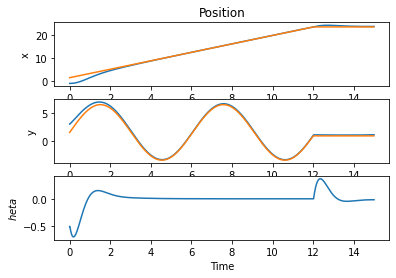

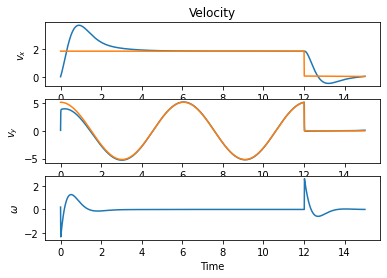

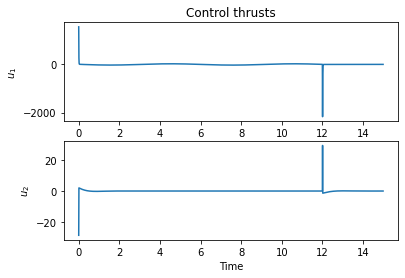

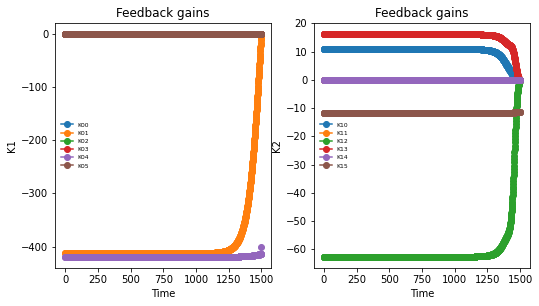

In [8]:
## First we use LQR controller with only feedback control
## Use LQR to track the 1st sine wave path
horizon_length = 1500

#initial state
z0_2 = np.array([-1, 3, -0.5, 0.,0.1,0.2])

Q1=1000*np.eye(6)
R1=0.001*np.eye(2)


P1,K1,p1,kf1 = solve_LQtracking(quadrotor.A, quadrotor.B, Q1, R1, z_des_1 ,horizon_length)

z_1,u_1 = quadrotor.LQ_simulate(z0_2, z_des_1, K1, kf1,  horizon_length, feedforward = False)

LQTrackResults(z_1, u_1, z_des_1, K1, kf1,feedforward=False, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACgt21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAL9WWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrh/uMdsT2wAAAK4AFvpH8E
LY2vMAnVN747X9YU6COah5mpiQjMc1aKt2JTVn/jU/u1ZAs1VZOpvPka1f5PwjdNy3eZU4s3lgJv
W+nbNwU62G3t1ge/zluZkV4UcLmRb0z8VNKWKSX+cMfwZrr6Cm359jy4WGwCqhi5uXjInAQpTRFP
7IxVZXkfohDpxpyUNrlvjnjvwqQKZ76fRJxSPLDLrLGqM/Agt27bIBBFXp7lZNko8Z+LnoF4RFEX
5UBa0gT1JIITDgmjg6ibQTCoTw1JktynxoOHLtf78Wg2WfdHMF1fjDhzqrsVB9bjRU27d3VKIGAV
f4AAGqsZje1KP1QhyWPzJe+PWM07s+q7RfidvhEsMx1uxACalhTWqdD4HKvRohFvrz0UQn/PLZF2
7FROQGY1+IeFTUI8rkZUZuNMzD3G0OaizjnLWSnHqaHtS47uzR09Xsv3pXFz8EdbN5rQwyhYSDAQ
t1+6Tw92WBBJGrXeKAkzuwDMHzzYXjwmdTOorUS+G7bFf5w4aoisVW2kDkfXxjT86s67ZcUEqSgY
L6ZKEbr1rUt3e5Q2HXGeTqBCafYr5s0WV3AjxbehSeEFgP7FkiBRfLM0knkwPDb+c/+ngzawllWb
0YkjKS1DC8uxJiZiW7tLpifcRUNQuM7R/9cd3F//yEIKNzqM/lFwjLMpbcBzQpKcs19gxLPAT4NL
UiGB812XdTilcHXznibLZr19VjPMhxqL/rIaVfoIC//abEYOTiUmeg1SAOP7P9mktjCphhdBlepG
azdYAHr0LH2Y8MzXqhkmlgkM0c//EDB0cjcVPPX5/pUtwkG1qY9snVFy/4JsV/SEQlzKK3K7aIev
r230FL9Vtj6vuFTBJeNsiEzrO6C9NVinqNUjpLu5VwNTQXe5dY772MvgnhHBfjoJEKbWPNfCp8SC
EFpOY1xMypq/p3hpM//WAIheTxlEYcaATtmcyL0Mv1V9EzihDNbcHXjB/H2XQALlPzFhTz2CLoCW
k9QU+QSqdJKB/DHrJgi8fp9TX2Tf47KvDXCpHcZwfoOBhOPixnrZi6ZXxcnxRH3kDl1s7rxrI9df
VqQe4QI9WJ7uGJda1rXzz5bHTY5+hAMyM7eVHWJBGKRH+a1vwSZtivBlnR17Fd7YhwFZVZy8BBoP
ZdMN+SYItIiswDfyzRxU1xbH0Qz5jkNaeg0xisSr4NzrLIybidM4PGe52n7ljfHBDpXliz1lZCfM
vPPmRrIaaQpH3xD7sPV1q6Dn46i2Qj9OKzTwjWC+LQl3J9EZ4cBuaTwlZgwweKP6r1m/U0tBl2/Y
2nz+CV+7TNJCkmXI1jP5HgadcgoMcHGPD90uDTOAv1MXjGytpn+1MbWicdmrqPMqQUyTtHtfm+Ty
gt1k6qqSHA9TiNS47yYg8sXpFuAK5/hiOoB//jmBSxh3R6C+sd1T1X7eH+7GNgYJmSaE6xT86Wu1
xHFYlnenY6P6wNIOQFF0cQ+Yld08EBGCGNPF38GrtOe6Fift0/M4Xk7cysO64AJZ2PKPMmPxm+BI
9zmMXdiBakHniZ/jkSb2hiwdO219bzqv0I0Vn4eeZQsYYeOqLCxDN7n6/ETImP+igN0exHdDSdn5
8TywXkE6GmXszz51nzMQOoxaYXvuTWgUpSjBWSUlRaSlddEUtGZ3MohpixqmORA8sznxAYl7pR1f
i0ii+FFJHabYtn0Y6JvVBaRGDcJWqsBbVAqdHcG225kt5Cy46/F/8T7dSAc9cdzl8OZcIoaPhWau
eUGn3PKoj5WGN3D32QAAUccHWx86KemcEAAW4HXrlLScSVdlSQPjGPAMB/KABqKkuhuHf/nQJFwH
EOVt3wAAGNrh7mSrRjBL228YoiktX9L8JCtgfaSNGq4n/ASkaJuhHI3nV7+fmYWdh1tMQ1Rrrtvh
Vx6iRLuMHtct+kLWMBXUyw0yxt1E+gCh5J0PmvjmxhOSKrHJIPhOm5eDj60YaINZTHORDJG5fAxA
Lktihbqpq6fTRWcujBXk/YIPVXO89zO+/ztYy3XyWvuWMGOdBsqDvKqH4ze9//h9GllpKGv+H6l9
vNUmSmoASt9rj8NEdznVaOBgXb/ougVQLTOEmvK9qvPLODgkv4nRUDW8HZv7sBKm2698mpmWAMDk
XH9pQiS033j/RW2aLApdmiuJ0wq8r/tHQ02LQ9VhOVY31qSpa0ZwXmpMbo3NZFSJbXCfAZZVQxZw
iCafHoiHyq9+FjyQ37dLhuLanSklqvPX6bjbtGAPiFfan0VWu8kmXdhSPX02LnP756W4zsJtl/Ne
K/Yg3Ta4IwOmlrXP1ae5HWvnDVBjZ81qdiz3nltXLUHA3YSijjOgTXJZCRmjp3VhVQaGUSmjKOiC
GMHth8f/0QAQ1POLDAdKH2GxrddarLcZMcqdx9xIjMhdsjSHsqtirGbBbF2YALECPLlUWAAAAwBq
IAUxyiMd9j3lXqTKU+3JB/7nDJikJw70c6EOUE1hkG4Eap0FgHvB6faiYkjZRpvk+5rW7/mUAI0H
W+gpZsQQuCIyZTezwB4C17gK/Ew1VdyiePL+x2Vxvce6Q5/GfNJarhdacjFUucyFi0DYhZfv9xMB
gv2vRVX88wf8ynHh+M/zEU9dXX+HzYBHge2CurXjVPCtYT/aKco3ZdQ2YYyEtns5txpGoe+Iw1xc
ZnXVpkgvEpHeu3C++mlB9yjIDX79wirXe+NCHKcbNu/XjzaCMRo/vslp8o9q2okgVGtqk4iv/+4Z
AtN/t9cE5IyHHzdQe2dzR1Fr/Ppmuj/H4ayVUT8o8Y4+CXBpZiccWBjChp4lCUPLsWSDdZk5pqPC
M4AUXhWftBaHQKvDN2Ot+

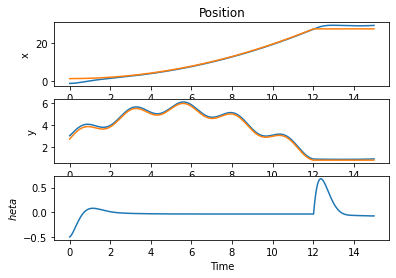

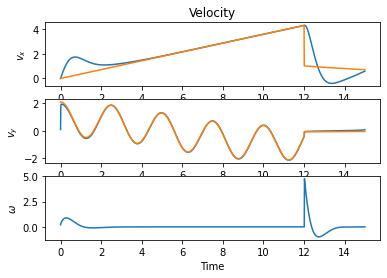

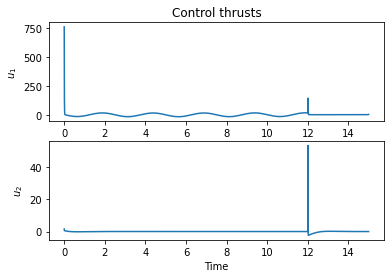

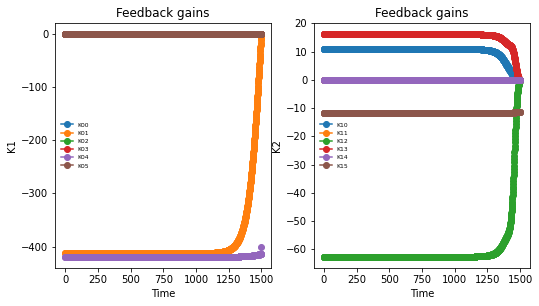

In [9]:
#track the 2nd path
P2,K2,p2,kf2 = solve_LQtracking(quadrotor.A, quadrotor.B, Q1, R1, z_des_2 ,horizon_length)

z_2,u_2 = quadrotor.LQ_simulate(z0_2, z_des_2, K1, kf1,  horizon_length, feedforward = False)

LQTrackResults(z_2, u_2, z_des_2, K2, kf2, feedforward=False, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAEwwG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALkGWI
hAA7//73Tr8Cm0WXagOSVwr3Ies64txf+EL4VK4AAAMAAAMAAAMAa8ZLf9ywySxnAAADAFYAD0Qf
8IWmsqADxuUWCdEIHEQ5tvN9EU43PP8hV2eiIcycf0sxEayBZqqydTecXWzVS/BG6blu8TEMyFL6
79b6ds2essCpqdWB7/OW5mOREEsk1kFL33pSFLnF38yz8RWaTeWaqOyZM15qL2EVI2mlyn5pNhTq
vjx4bQ8x/sR1zzs9/3Ywg6W/6SoJ1XokUnXC2zOKRLVByVx9m/qY1DcA1a5jCI5/bPp9Wfwf703N
H/aBtPDupLjXhJoKt5JCFaHA7frQ21h6CMCg3BWgfuAAW+jrcXOHgvs4IQBjMN/lcPti+U1CAcFp
GVLixdN7iDoZCgaHlGyB4QaTpSDc52EnJV3vNEQ1AN+nyE/55bIu3YqJyKjGvxDwqahHlcjKjO5p
mYe42hzUWcc5ZMwhdTQ9qXHd2bDV0o8zw4FTV8Md97oZLT91dd8E+qep5wwE0g/9qrhgOgK/OQDo
TAmCKn6HQmoW73as8mIBByGr+BY2CUqxFS8tOZEmQ6HV+K+OZDcisxOtLPkKVz2L7m7lzamvIo+V
niqH9QSJtJkJ3USmVGR9IfmGrNu6e12w4k36nf/GIYpYH+UvyndGbVY3sCUKyfXIXFWsqXvL37vy
vZ4BUvNUWViVj2jAfyv8P+F/xA0SwCRyiEGChVLRWLWSvSYmvhfT1WcAAAMCzEJDeaFpoDGENgbe
84r4Tb7QpWBhzYANIW3XXZ0Am7IxWi0h/SF3xjwzNeqFJITCQzRz/8QMLNceyud+vz/SqOdK6NDB
7ZOqLl/wTXUp+oNiF+eIjCSM04Cw+wpZEIcOi1jnvgDwiqnxZEueTPmAxelYIZgkk8glhmNnNnfG
8V1TDh24+mrqj4DZAUsqazrpYjzcZR0QQxg9o0f/wAD+mv4L4KHJrQbnftkEqje6WyzaV2g2SCVx
/LUcZ01StaVW8m9qZfTXykQKex27/JRAtUQdZKPv9nh0Z0D44AAXe59FpoCBrprDAVkMZNMAqwMf
nWBtH1iWuqy3aT+8GAssjapkRJFKp42flUBoOoyt1u4508ZNGUZl1/38NlHGlE+ge74481He5h8Y
7mREEMGWUleQ3Ov97xLFZDyhaX9l3vrpVHfCkYInFg2xh6gqX4HFzo5n7sQ4JsNINWj0ZIv5lSgU
Dlj/yyFKFqcbyuRfgrpTGN/DCZt3z5sN9bPHnFspY1n6zKWu7zY6P7NLlxUfxLQMjRwx9oBsS5v7
1fBfuAAC0hjEdU/61eH2oC640N1acDBQFXZ9xjP1lTaShqMfJ3E4rcH6eKP0YYqrqg8St/wARM9w
s70ZzCMwuphLytssUvLQmpuBEMgCn7Nx5ridhUPVvO5XzifZUXUAj3ab2PTW5XIY4q4OiRSQrbJ/
Xt/Z5z1tInjCevUBsw/M6SFsEAmcFZs+6tECECyu63oZJuyabpa1qrd3peijWoMQVh2wrwGCpIwH
6p/6p+qr6+MLpMf/Em0lhOoEdZgUy02zyEzP4pfAwR7GK7j9/wTyEjxdCyILpS6Mobl87501P3r0
SWRPKOVbKvqq+HkIqOC6sU7KX+477bimGu8WMtUfG/5ngBI5QuLiWQlnENKvV0NEIxsEIVNoDOr4
iIVBYmmsuFQAAAMBNOilbr0XGWRH1mkWUBWvlNY5SVdG0XPxL5SPjlwnTYNyIg2bgMAEYAqVEaAv
7/dtV17o4TWW29nowPf+tjYI3o9ozOKfNxvrPxO4m8fXHfAnTENTvbaV7wXovpyg5h6qR36QtMOy
pmBMrTcoRb0TUa/0DEwzupIc39sgH7LnP7ar0H/yLuc4Z3Jtv1ugAj3XyE26hk+YwYmA8KyiJKcQ
auSPGlREB4jEzFMjMvJ+0SfTfTSFAoCeRl9H/UjeFZ2uY31rGp9NxikaL8/f4JUIdn9yApY2dDGR
5CKO9KDyKa1A7TcVjdAEVkEh6pcUJTmKN9lsE0t9Bc4S9f8/g6LG6tGbj78l6lmi3UArvIYOP16V
XgftRxoMMzOgr0nYbIj3XKkfemXkZy5UeQ/zPN6SBIClbR0NP+xHpOplpX+8cH5baP6EZ6fYehUt
i6tfx/c2Q9jZbQhxifHoiHyq99uXLW83B+Sc6C1gSLUXnr9Nxt2jAvnqBrtIr7boCeMqO2y3yKwx
KBICshkLBoOrAZyQeN5uERhqqaQGBxMjzrCL563sOhFTsWe88tq3DXwy/mD6C28Iz1bLkshIzR07
oRVPJmcddo++0QhjB7Y+f/lgA8MMs7RaQu4nhM1YDN9sglUb23VBaQ45tzY+eFrg4wDS5lABP/IG
aoWsdoEh9QkeFYIGsmKTRDFq9ZHZXt8F5xB0zSykzqkRc6GDze44GwyUqpJJEVTPgYWdzjEf9eb3
HyB8oLus3L1G5TH3ED6QLQ5J6Fk/s17QBfKAWsXI0cJa1VdyiePL7RLhbQodP/aIb9xL1lwutORi
qXOZCu11wosA/h0uRbhvo4qVgyrehTmIqM5UmsQEmYAOhN2zPlHFglzCWGfO/BCaZSBAjYIOxc12
r0Asjw34gPTVHxhzU2flHOhcdjLQLNwsRO29KWvEbZEP/2hBpGOc2WczMJHZPuTH92VIAcs8Jm43
YDUcLXJIEePplsl2RSl+zwRclUSnWUY5/5fCUxyuYtmakmzz5dB9GjZWgCmjhO8pXe7/VsVhLW9O
Cf+xAnerhSmf1+RpJmxg0R76AAWZVBtwy2iiSYUrDBr/fomtXc+WWq48q9HaLAUgWmrzm7/haz5l
WHCTS3TOe0B4tarI1GxDmGfC1CfteZhm+H7nplFJSD2t4i3NW69u21w+F7vuvzfJcTkDMkXgXlAx
9w9O/XCaogmEY/1gFLR/N

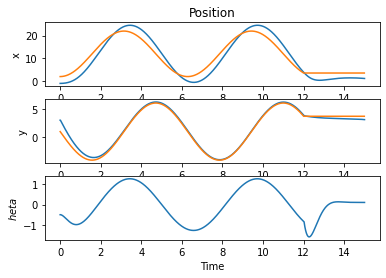

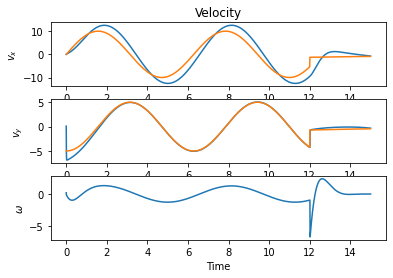

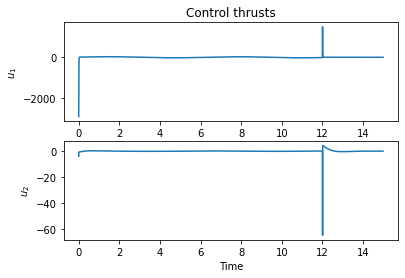

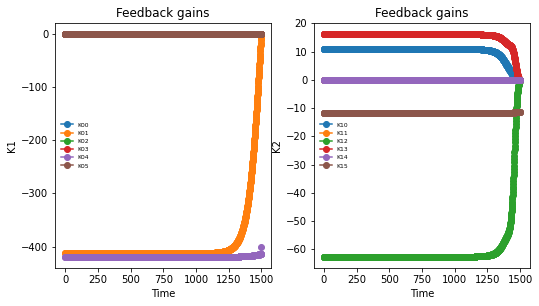

In [10]:
#track the 3rd path
P3,K3,p3,kf3 = solve_LQtracking(quadrotor.A, quadrotor.B, Q1, R1, z_des_3 ,horizon_length)

z_3,u_3 = quadrotor.LQ_simulate(z0_2, z_des_3, K3, kf3, horizon_length, feedforward = False)

LQTrackResults(z_3, u_3, z_des_3, K3, kf3, feedforward = False, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAF+321kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAMC2WI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0ALZS34I
Wx3uYA5RDRtbShrl92onXtCOF3soqrWRis0abaOtmJtHCBZqqydTegpXowDXBG6blu81O3T5l9d+
t9O2cBKqBU1OrA9/nLczIryI4Xkh9t/671UsUkv9ICY3SvO6wXSAhh2uPNmy8MebiUuUC+GoeCHq
MSXdj/afJfZZMxPyhqvTANK0V9AEK+AbWoJlYBKoiRXEPKn6MVbSy/BKPn5N6DXa2huQcXIfT3E4
V+ANmXnawrhVdLl/QDmB9e9/f9JHxIu3iyHSMPp4KagPG81bFhgfC5ytUtS/43VIGI1Wt+nrswls
FyAsuziKVSHHy8s75AukYw4AAAZVR1EZ5D8sOEkRx/c3V+YtxCrJGHJoQV3s3ooCHvZyIBJIkYOf
QpmaKh3skentDft/gYDzYGt0Lx5trpg3CNWagGfb41aDdcEVl4F96dva4xI82yltblMLitCe8Fqt
hwKmr4Y+gfHGi7lbg+L10NbHXLOiECK6Nud33ALZlCazhxlcacMfEOnBW9NYu5CnqdRcwd2+v1qH
PQtKQzrtB2c7vYI7ZX7x7ao8rCF3GS1Lf/kSueAiMcC3+PlRaWeugAGCkel/1GwYf7QJ7FdVNYrm
A0qBVzFXYNrzVRUzAD7wxsW7NZqe12w4k36MT/+FuYpWtqnGEvdGr4sCmBdmqB0HeKgjicwCXDlu
Yhb42NtU+/3HbmgzAI6Il8dava8J5piCg4dt/H4Us2HP8+hKOtffc7bkslG4uJZArAi2Bdqq3My1
XgdZGidrA5T5VR/q+pfyJBtiE//58KlgYYy4/DJXkXPjC5NIBdhsmZP0eD4pQnrq3DEl7En6NnWo
BZCe7ShZr3J/0LzVSd12krjuDQOr77rejN98zovzO1zOFucUGpdeRQdRA49oPZjHHzaLLdzQ0sLa
TSttaVsErl9Q2ooJRNx7Huk7kUfbfIoKBMnDpNxSkjaw+Y/OKExpTk//zABhHEs3O2VXTzCVWv8S
8kflGPDevbS+Gp6FEeuS7IPyAAn0/H58V2eCul3uRKsVOiucL+i5XC7XEbx+ax23slo/Dxlz1pdU
4T9Ya8xHtHzYL3rkhKFD93Hmh3j4A+Z6N8dOiCoO7pqosKZyQXxLZkPQ4QD2YIdTnRbyxSSDpxZX
iCnCDpzFiSEi6P6D7t/S7r2K728/Qhtlnu9+d8UUccEU4F4tIcK8mY+Pii0aHUp0hiYe3Vb4LTj6
Y9OxhKQm/kIytUXIWznMaFHFV1mvxprGsJmPz8shKmWWf/LCEetlGvpqgNWs4hKmecfAIvGj/whb
/u3qq/FpUtycWHH+XfugkV9AIUC/w65FKxM7T9BMLpn4fr+ysD8zs3/7wwA74eZ6nf/ryvME4uoI
mBhWi4HgRprfJ3zz2biIwiihU7pyD3h2LrXR+lyMS7gm3x4BiCMcABjDLLNb6PYGLe8dZQ4wtbba
T+Mui6UHsbuva6EeS3ojUGhrMxHugFDGow97oiV9cbs2wamUZar1RyrFKl1vnYxxs+GOxpIqiZya
kRMcag8eEawj1S3TcsPY+D2EQb+4htm7DheTKPHIwiwYXT/i8diqoHgg3WilNRJ943pcVDO1UM4z
RZu9xun3/iZ3cgITJbzW8EfebxiUw/il8BROoG2A0rh4Y4G2xmLIeT+JQsF5MbPzLPyhQwQrzpOJ
KPl/nyjUe7vLEM3htNoNmeITf+ysu7nUNx4ta4ACE4jcKW5MBTZYWwXzI4R7DsAofpAWh6qxABN9
MIwNpMb6z8Tv+8sws74E6YhqocItvi1x6iRLvkXxmmPcmzl8rqZYvjcYGB+9Ij6sLePVFgYlvs9b
rOljxbVlLHdBDfAbgllSBPSWMarmnNqMZHRp1OXoeCcxbbFk7Xw7JwGgWkSisvAFTmcA8HV2y897
MA3AJHOtvs8kAF/+IgjLW/As6ZxoUQbwPCSDtrvM+om9JJCl9e6dF0Zs9iAWUMWCnWepSYct5Q5F
/HKFpP59LQN+UgwFlD06om3hv2qM9WguJT4T70sNYp7IzP/FtZdhtitLFt/PWjWQUhM8sD3IJ9QB
zBxQjPUoP4USa+0E1H70UrQgvzXTvrq6jdMcXhdHdlXsntjtYt+Ag/LZyiSVlmvcnti7gQfcyk1g
AsbHSVzuxRIChpz7BrTiQESadWDFLu6K+WQLOQ3IeC5XVJxx47cyoQicJLtutlBUUIVIg1VFoABw
JnPdyjA24A9HlBikYxeoINA31H+QpK7rfK/cwyOdTIcKu6IIYwezNl//NAEAB1X1vhnezEL2krrV
ZbjJjlPWk7C+QwWGzgRObByWapJkcwAMk1hSzTZiIfO79Lsk0laKGBRvJvMev64XEl+jG0sEZ+Z7
+s+doYOA4gp1DMbFE13lbH+aj5Y4HILcM1MH9bKaYa1UxA9ugufJSbLOsly9XaXaAcNO6TkGlC3r
PTIdrjbMCF6SILmPgPNPlSSc3WnmPrs5x9ALVIf9WajKCCCAm3yQB5Po3wNH27TGpaUNkQmc36cD
zOiBUTE31LerxMD9qlKtxGvvNSI/sVdcaFlg8mx3ITH1Cmv2bTHB6qnaCtzgR9iuN7kK4uiEazMf
GjlEnIxXFyat4oCxCtFu2rwoX7soGdhJuc3yuPLdelwuU9dXUBVoIPAkA41xpHXrS7hOdUc2ea0W
UwRR0PpY29W1NQWsGQhSfgbM3TzSiJ8tzW9NreHgrqFIyd+4WBdVNADzT0J1XLRV6AgoCpX5Pwfx
DfejhnFzTpKg9It//H3nUlbd3FxMuk3GVUvYezzJAYXMXBjXR/jaBwthZQ/a8QrkEIRJwsZJqgy+
ErTV0V369PdfwhL2gMPL2

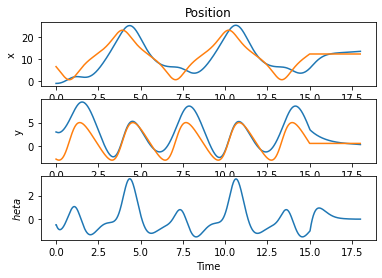

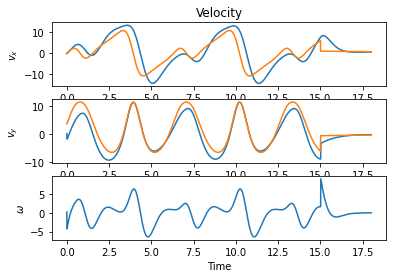

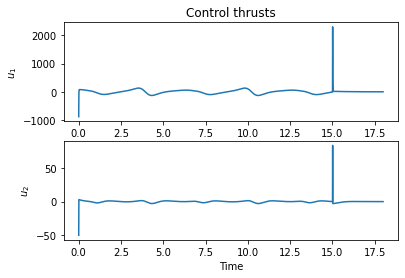

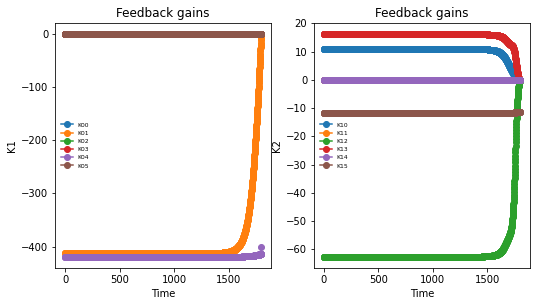

In [11]:
#track the 4th path
horizon_length = 1800
P4,K4,p4,kf4 = solve_LQtracking(quadrotor.A, quadrotor.B, Q1, R1, z_des_4 ,horizon_length2)

z_4,u_4 = quadrotor.LQ_simulate(z0_2, z_des_4, K4, kf4, horizon_length2, feedforward = False)

LQTrackResults(z_4, u_4, z_des_4, K4, kf4, feedforward=False, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADzJ21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALuWWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0ALZS34I
Wx3uYA5RDRtbShrl92onXtCOF3soqrWRis0abaOtmJtHCBZqqydTegpXowDXBG6blu81O3T5l9d+
t9O2cBKqBU1OrA9/nLczIryI4Xkh9t/671UsUkv84jCueyWelNfgvlJqx1F7CKkes4Sf80y9LHXx
48NoeaP6+BugzT774TgCZ4LvBxTHKXvK/IHVc8qmtDmFG5sVYwLM5Cv0Kr3gNjoiPlIU/xY+heRP
UrQbQtvHx4HOgirIjspv8BCBg/LqqPPmmKfCtTMrfMTVjhvF5TZHniBQAPKNl+J5ADaqswDt1Xdf
vaCirjlNDGTSAcgcAsVE+Idd9jeRW0HyAF0UAwogWFnthOqc9gl9UnUkS4/PACyTR5Ux6iaE/9zG
/lJdvuPoJPHUO1YZEcEfx/MjPZ0oH+TADfk9Buy9iFQpZLDBwY63xN3OxDhAn9TMflZlq7vR+6b9
yNF3Niu3Zi+OEUBITYv6kr66qSqQg/4xEnUjWinjfR4OkEGavla5r0DwpJM3PaUbgU3ZAua6detM
bHYuo+RtHokgPPPCvu86FHVbN6qxZb3SSIDLBIrBXGpPji6dsdD1l1GMZHlU1htScc7riVjbqaEL
CQxI6/cUS19V3iTNp6pxAqLKxf/seAkNhmJUfIOD40uQdPgIOWTVyt2RGu9zcmtY9QhcwuFlD8AT
aIdhg8uXiPlQqybrPtA6XkIrioZChAAAAwBm2oDdjiumRUXvOleYZf8MQ+s+GkWZYyufac5xfkqW
NDshtWcdA5lw/NRV6A/gRW3HG7gFn8U3Ud+e82K9uMDukl3kYCVm8HHJEXgDAevu938A4gNgbE7c
Tdvj7Y43yYNjVqYLBvCj9OZAqwPKNBg31jgF0erSbGVWVkUjyOuie1F9zWOGKvphNt6cfGlQmfja
Fi1WYyvHyunJ6iA/LX32f/+uAGdasVkwSu6RwyRpbRObqSGY9/thUNvycY/79jrrwpph38GHnBAS
/H578GaGdnEljGfYE9JSK4DpGuD1wXf0oKO6i/dRQ9GMW6b5e3HRMRFO8JBXwBEfdujsdgjyOhqr
jzYZulnQD1oyIs3nOkhURqyjhpL7YjhplBydaF2sDMEOpzouZWv4505G8juDs5j3SlvWGiv5lD17
Vv0mo73L7z3Y2I9mOxtf/b9Y4bYLmP3GJkH01qlNcYQTv1vwJTOPpj07GEpCb+QjK1RchbOcxoXf
kdyxvjggrxKNH/o30n5oTt65UeAcQINY+0KAagqpWOws8jiqP/7IM226VGXVlYj94sOP8u/dBIr6
AQoF/h1yKViZ2cSU+C/7TJmANY+bxhBEeUX3E7f/YnDw6Kd1XSyW7AmvtrTU1ClwppkrjLeByQxO
ynB89xRmN5SEVCb2G4YVNhqDvVazgtXD1SqpRDpys3PfTsbI7gAPyimWN8lQTXqQDbqTKrb5UNlm
kN4rASvqFUgBiT1GUVhtIIM48uA+3ibFGqbOA6hg1l0U9oBzFZjThNxtgW6ln43P+SXyJ1wt99sg
BJ52wQNWWmHlOSvMZbb9T8GXpMvTMLt2CUY15oNlQza35Kg6cbNFm7ewynGEqOwkJjDfpanr3APm
rEkiSrEoVe0WLvZdD8jTD6+B/Or/Yt3OvepRFLcd0n9alRCvtIFibfBD/1u99yg8T/IN8r5lYYrv
ITM/il8Di2Y6aoqtxq7mB90ZUk656hnv8uWISdvRy1urNBE3TAKDlsY/1Xg/wAAADprtJ7/CVhO7
mzc4cxD7E1Q9n/B4n3/BELlrYpgzACTJohFifTAfkhdsWf5IXncUVhHiYy+6RF2SI+mBvoumN9Z+
J278ha47DraYhqkD53Ypvmem0AFnYv3sRL58u0XQF+R7NHIfaeUkJ5IfVCMVSiQOSvItMjS6jAB/
C/tOmZl+JPc+anX4eZ9pWkVspm/zeG2dBJ0iSeAgOEy9ztcenk2cQeMmNDH7DziAz41YyXgQj0LL
C5t2nwH//iAFJWDf//rwzCj9o1D0gI1bMs0Ymy0Fg2dbYfPbHLiKjIF5Vzs+/p7olG7AAAADAAwr
Xr9pc2A81x6HDMzoK9J2Epep3sc5M8aZ/lqQA5moKykVCNaLuFCZiqA0brscqxvrUlS2Gzs3Z0LC
j5dEUh1tcJ8BllU91bhDjE+PREPlV78AHIn849DjcW1OlmhqvPX6bjbtGAPhYadT6KrXeQlj9trF
xXVTss3TTOxiUCQCeJkNBQWsSaVrNG9P4trW2IUYrjFT2S5XRd15gqMCOY3FmLRtbTTjxrrPBnKR
Mq110u3CXHdFxwX06H77T77RCGMHs0Yf/fAAwNrmIhp8quUiTW661WW4yY4+PrpBfWLOjwp5Qshu
lQVJMltp4+fAAAADAAtzLrLM2RkD34INTwECKWJ0BeZPnnsHUZtBaQoMIHw4ThIWjuskcuwLqGr1
JO9uQtHSGnaLSlbM9gQpyAB7+SGzTNAF8oBaxbztoYTAm4kp48viKUft1Imf3QAT2cSCkKewdEHw
9pHvclEEk9D8d6GKiDF2aTbAkiJWYyd/11dQFWgial2BDVaOlfSaq0/1R4NqKpfRNMZCWRF2m2KN
NMHefhcyTOurTJBeJSO4aZYE8vZusvlF8wer236SoLp9oBr3xdvdPNoHa2o+l4YV7r5uHaSBUa2q
Td1//7ZkC0xRGpuKF0m3dVL1lNR6Ootf59M10f4a6WSqik36t3UUNNbXc5A+o6HbWZzg23sYKm3O
qAAAAwAB9+hRAUE6CQIMRnsBSB8wt5O/9vfUzOjSHtX75z2gPFrVZGo2IcrrJTrUk/bVViA/hyrP
s7qeslJbmrde3ba4fC932

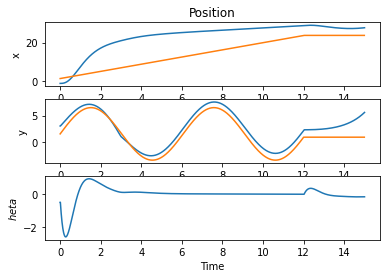

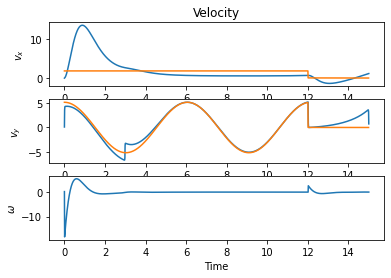

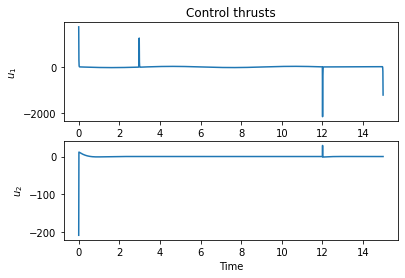

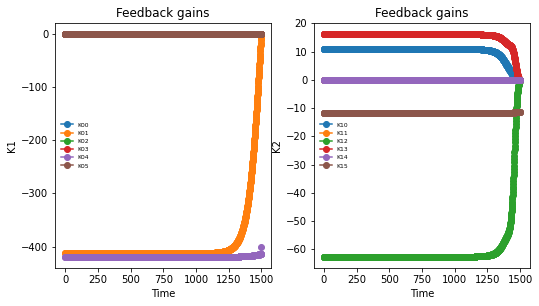

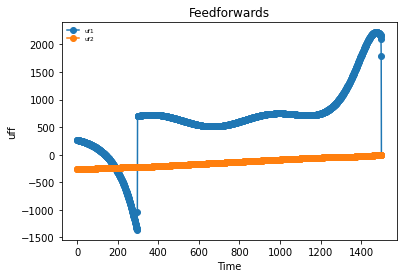

In [12]:
#then we use LQR with feedforward and compare with former results
horizon_length = 1500
P1,K1,p1,kf1 = solve_LQtracking(quadrotor.A, quadrotor.B, Q1, R1, z_des_1 ,horizon_length)

z_1,u_1 = quadrotor.LQ_simulate(z0_2, z_des_1, K1, kf1,  horizon_length, feedforward = True)

LQTrackResults(z_1, u_1, z_des_1, K1, kf1, feedforward=True, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACjYW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAMDmWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0ALZS34I
Wx3uYA5RDRtbShrl92onXtCOF3soqrWRis0abaOtmJtHCBZqqydTegpXowDXBG6blu81O3T5l9d+
t9O2cBKqBU1OrA9/nLczIryI4Xkh9t/671UsUkv84Y/pTXeXDH3QMlbdnZ+f81o9A7Qn+qFzSqe1
mZNU2+VcpNv6e1GmD4hJh36rg/cGli9ICJSWmM3f9AtgulzME8nhVzTgdgvGOZm/bW7VPcH0oYrZ
71rZr6X/J7N/fsLQtVN1pXWWo/esfpdy7Pk21D93i56GkUMEFgiwIZaNF9M6JfR/mwElgAAE0/Vz
DEYe3ouxZIAKI3zwI4xbfyAPLHMf1LtKAh72OsEk/k4dG9CmZoqHeyR0/hUin9njvNga3Qu8tY3A
B4VNQjyuRlRqMpmYe42hzUWcc5YWZ2njawC64ULYMDvea2h5tdnxRfI+7R0ku6jwq+U3dFCvuBCF
VaiVHeraL/ep3mm09OIowBT6Z0oxXencmyLo3ZmMNmIJFaANTNuUcEe65iObpnZLyoc2FVKGLcWG
OfITUdnla/P718E+LreIysEQLxgqT5ad3VH0i7SurHHW6QmoR1zbZLjzZ/9RufofnzMjGZwA8gHP
Ln7vntIbt+gCio1B4z6XUSe3gGYEGYA/u6IHnWrGrbAqwDFdWXDs4UXGAcH55Jw42qeQ29lMJzfW
It7WrUEQGzSC54AA6fi/w90K93hUeB43/liIVsAD1jmQj+6TzwL8lSxodkFmKvpJMuH5qKvQH8B1
91BIZo5/+IGCvLnNivbjA7pKHeGVZ8R7ZOqLl/wTPDXzHqg+7l2XY0RHE5H3kg+FXLJ4pTs1ggj0
az7Y1vzLmBZhfy/mB4RAZugjkNK8EyW/rCl0zwHG0uCXubuiFvB4Bv2ZZPigwmZh3ze2UEc47P/+
oADBPz6/NPfMLSVsVZTWiHBECEeY76aTyn+7VKf34NoopVjDBu2bicKCnEWIuuBI5al6zeQ0uf5T
DUapwLkPK0m6lnZ2Cdq3f/yD5qt7qOPwPF9jyAue+JZ4faRYup6C37Yb1gqxqcdSVrasZPsvYmh3
09h/qWF4KkSqGzUbVxbZkPQ4QD2YIdTnRTVyqSDp4yaMqczLN0BAqjjzufB9PKdGEwP1oeijYV+2
jK9uT8n2378ok6LDw01jHlPVTIdKLg/fdk8nH0x6djCUhN/IRlaouQtnOY0KGlgZIv5sJZKrHl8/
LJe2OgTg2WENTp2m9j9arHv6KNxYM8eQa0z/iryKTNXv4tKluTiw4/y790EivoBCgX+HXIpWJnal
Zcx40irH19Tdx0YbwuuseOiKEFqH96HlH6ASiQHJZRnGHE035M1PN4HKfBTK1Yh97fOzU/1rdMOA
GThYklUAx9zMJmA4ZopJ7M+qiHrUxO+d/YACSvrI8RaJ4AADCEs8WP+8D9ecExkXbFpV2/3buxnn
7cCmKA8avhhL3YC3oTWCrGb7eL0hzbwtNpEqRAhyiG+h9ZW5lRIgGNgzy8BGoCM4xfiogSZ7mE8M
uJapgbAyEX4eCKJMxztqCtUvkJzOUvxvQVjAqYP/xe2Qz+/iT5Z9PDVS6AQgrSxyXhISW5S0FiGb
5ZCi7ORMf9FAblP9Be9TpI/dUKItiAK6ONMICcawlo1CAvT+bbD+6uKGZ5RggtRSoxNFi7w+TbkX
mJl2iOV/gNhkK+RAekmmfwI6BvcnlCpk4wIDv/1G3ndjFMbavzovx6HW1LvnZg/vZJ2svlTS/8ey
uaEnnNb2hBemrFeQmZ/FL4F5bfbQDfj9iXCR41EAAQk65Q21Sp/PLmkRGeXIn2XoL7qqaqKlLDyh
/rvfvysQu/f4p1O4ciOhdjMZqZmstQXLlnlKdDQ4Bc1d2IPBmC5+zEwjbvYtvnkiUeBcNovv+TcW
cpxXG6b5bYEaqRkyUr2nKfSgaYjvfHnmR1Mp9hZk3W0c9br9sIBXRGYbR35MbriRwxRSzVdKieWN
u6UlmI2XbDZ63j9QbWOfaRRRPY8JdrqVVcUIFcapJTeWUIuR2SSI+hN3Ii8MESb0xFm4rK44ELRn
LR06Vkx76oK//esKCfz4ToDMH5hGQj6DaGXTCIKu+MJqdRSJ0LBdgyBLfr/XUADiXCHB9hoAAAMA
AAMAAEBN/dgJSrLlZuzsBGw8txfwGukl+Dcfel5QcHNUf7Rmb8zaaoapIfIZenUX8QnKsb61JUtd
/Wxe3P/2X2cIKv9a/j+5sh7LltXAJp8eiIfKr33O3afzj0OKve9JIqS/0LBmNw6i1uJvz9N6JFZr
vglHn1pN3tQ+4/T9REjqTx8rSvaXQ9ekFQ+2g0t3So/XcNzhoHcV7gSmsy7V5XMYvhavqz7xIWg/
XBQD0QWer3yGeh1vRftEIYwe2VD//bAA9sM6JIvdsQKC/1YDN9sglUbl3rjdWHuEmr088LXBxgGl
wz7YhsHBcmoAAAMAAAMAjZqMUVIaYyhobleucMVa/nswfD/TGvjtCkdv79YUhIiqZ8DCzucYj/vq
lvdE3yg9ecGu3mbzlO9FwMpclyAHSmzXtAF8oBaxIuMGYTAm4kp4o1xnZXG9x7pDn7eScsrub1py
MVS5zIWWNAYhd+/wn0MVEG33PSqBz8KMKj4bwyd/11df4fNgD2T5s/bNf43bS+ypA1U7E0NUJL/j
yZZubstsUabWc7JC7mO1aaDJBeJSO/NCq6eYeIC6O/U7v3LaUWXIgwIBr3xioqNAr6E5L/fZLf0p
5uHaSBUa2qTfvf/8ZkC05U6lNI10m/Jv1B7hVtHUWv8+ma6P8ZeLJVQtI6936eg7cDOANbVlKDLi
aXPwBdHeJonVdlaJN6I10

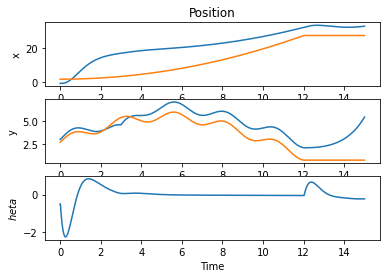

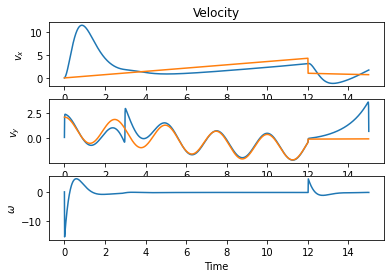

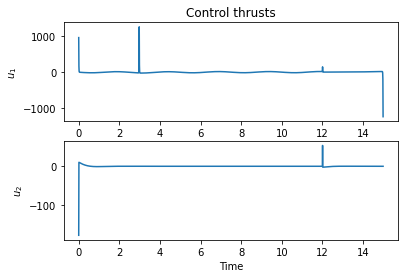

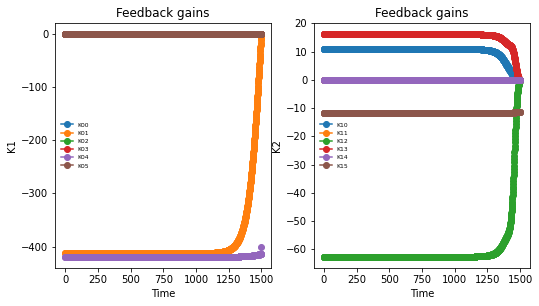

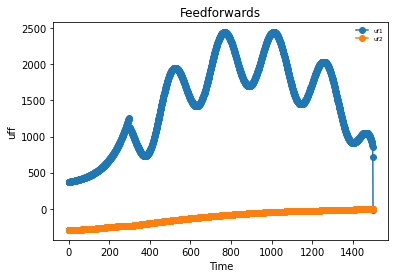

In [13]:
#track the 2nd path
P2,K2,p2,kf2 = solve_LQtracking(quadrotor.A, quadrotor.B, Q1, R1, z_des_2 ,horizon_length)

z_2,u_2 = quadrotor.LQ_simulate(z0_2, z_des_2, K1, kf1,  horizon_length, feedforward = True)

LQTrackResults(z_2, u_2, z_des_2, K2, kf2, feedforward=True, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAEfoW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALx2WI
hAA7//73Tr8Cm0WXagOSVwr3Ies64txf+EL4VK4AAAMAAAMAAAMAa8ZLf9ywySxnAAADAFYAD0Qf
8IWmsqADxuUWCdEIHEQ5tvN9EU43PP8hV2eiIcycf0sxEayBZqqydTecXWzVS/BG6blu8TEMyFL6
79b6ds2essCpqdWB7/OW5mOREEsk1kFL33pSFLnF38yz8RWaTeWaqOyZM15qL2EVI2mlyn5pNhTq
vjx4bQ8x/sR1zzs9/3Ywg6W/6SoJ1XokUnXC2zOKRLVByVx9m/qY1DcA1a5jCI5/bPp9Wfwf703N
H/aBtPDupLjXhJoKt5JCFaHA7frQ21h6CMCg3BWgfuAAW+jrcXOHgvs4IQBjMN/lcPti+U1CAcFp
GVLixdN7iDoZCgaHlGyB4QaTpSDc52EnJV3vNEQ1AN+nyE/55bIu3YqJyKjGvxDwqahHlcjKjO5p
mYe42hzUWcc5ZMwhdTQ9qXHd2bDV0o8zw4FTV8Md97oZLT91dd8E+qep5wwE0g/9qrhgOgK/OQDo
TAmCKn6HQmoW73as8mIBByGr+BY2CUqxFS8tOZEmQ6HV+K+OZDcisxOtLPkKVz2L7m7lzamvIo+V
niqH9QSJtJkJ3USmVGR9IfmGrNu6e12w4k36nf/GIYpYH+UvyndGbVY3sCUKyfXIXFWsqXvL37vy
vZ4BUvNUWViVj2jAfyv8P+F/xA0SwCRyiEGChVLRWLWSvSYmvhfT1WcAAAMCzEJDeaFpoDGENgbe
84r4Tb7QpWBhzYANIW3XXZ0Am7IxWi0h/SF3xjwzNeqFJITCQzRz/8QMLNceyud+vz/SqOdK6NDB
7ZOqLl/wTXUp+oNiF+eIjCSM04Cw+wpZEIcOi1jnvgDwiqnxZEueTPmAxelYIZgkk8glhmNnNnfG
8V1TDh24+mrqj4DZAUsqazrpYjzcZR0QQxg9o0f/wAD+mv4L4KHJrQbnftkEqje6WyzaV2gwzDEN
ZxURmHW0y5lWO71uBvxgKZveQKWe+OATqXV6VTpJRP+z3O5z4ncAYdFD6xSI3yL6AspMPNKGFgno
eD+v16ADhxuX2BYtNnTEQeFtWLn9CGfJ4qweJIpVPGz8qgNB1FSdbuOdOLK8QUWiSbAe7vwSZSjK
T8hq9diM1vYZ93Cs9MEVYavmW510PqTosH3OtrshePaheKnSGBqPNz/gtesbuuB6gqX4HFzo5n7s
Q4JsNIL0A91mvxwQr3EOPz8shRGOO2uT1Q02UbyXwA67ntA4LYffHUWyxfUjF388Mpa7vNjo/s0u
XFR/EtAyNHDH2gGxLm/vXPzBG5hFM2wAAGM7DD2OP/BTZII8rUihuDHit+bnWCaF1hCzLFmFGbUh
VKnMvZWZjKhcCzRYK8CvsD1KsnqqmA7ghPCm7A0QslmbzyRW3j2uP4tC5eSaOU9oEzclpjh5HnD1
mf5opCUhkf/F8F/0Us4sqcsesDOpHDBDzxHgo1aF8cnEEGXfyX3vwcJTrSPu4C3lFabA05J9G2LH
+FIV/HH2Ju3adRpyjGdJRzkBkxBZfmFYMe9dRw1EQk3Uoii4PxMPo2BngjjCzgPTSFTP3u72QD3B
fJGsZJ9IzyEzP4pe+84xs+ZvQbRZ7xL7Yoe6EEQs2MnVUffnw1c/YrBpqr19VYmdA21/Y/iVZQDQ
DrHgy+kykgWMtUfG/5ngBI5QuLiWQlnENKvV0NEIxsEIVNoDOr4iIVBPSGsfLPd7xnHxJhW4Iyy1
1mYGe65FaHbWGgpjy7H8TUi8A5/L3II+OYFZZXAnzOh4SBoBFqVpikeOo8eyE+CGsXtEXXaKPRzg
9j02QmHx2LmH7/2BRs79+5GZxkZuN9Z+J3H/k2v5h1tMQ1ablkxs/Fi+nKDbgAi9/pC1jAV1MsIR
Mbp1aZnmVfP6wo9UWSkVQ+scqapCVHpzAO6X/3V13vkl2K1JMv905WPaZnP7XoeZAIK0GLnEzlim
vp48iZCAi6XbsafFSN4Vna3y7Rim0p+jmcJQI74cleRRkwf/2TjQ4+kKPl2jUWCjeSkBgYL+Kxvv
2/6BPY+5cy+PtlEV3TqIEvnblCZNbtrV1AX5aWv8dIdpi4JnFp1H/SL9MHZqv80GGZnQV6TsOrOq
Y3q1/qqgqcNHXvyirzekgSApW0dDUKdsbrscqxvrUlS2DO9tq5+oGHREUh1tcJ8BllVPOXTCOFeP
REPlV789H/V/jQCyc6C1bO3UXnr9Nxt2jAHwZGx83FVrvKQ4+rstG1kStFms09J2E2y/mvFfsahF
a5kb/E0gMDiZHnV36ljvzMI6pdTsWe88tq3DxXY0k/Rq27grZrLkshIzR07oRVlTAiP9o++0QhjB
7OQv/lAAvNrigmTKhDluxNWAzfbIJVG93PUcJ8Cl6sEOULIbjANLmUADhMLHxr9Fq9lTSI4+0qBg
yhg22py6L6YNROKppE/hKLEFc/t9Jo1/uNbwNRLpc4uLP2rPnhEqA/1WRyhtWmdwQa/dlQY2sEkP
8pFr+2Wi2oowaNleTcqFfDM9h2XJvfSLqilE/ym+a4xJzMJqDtXaLfzNIQBouKZd2Yls9IJG9yU0
NTaypYsKaSGVfb7cExAf6wmJFycj2n6LeabcDOv+Yee7BF9O1WwTEcO2lqx0SKfVlDZiOymZBagd
2PZ6azSlp2LcrCvA0zQqqJdQ84EAYepW1XwRXQpUC5kapyJoH+ohZQp9L2+sPpSr40aESlfv/2Ac
BtE5HATVof/8L3gxmPwfQJeH3m7QEOBMLWdaCsznyld7r9uitl17hQHmfioi8PooKJBtusvgWdxk
vSj/QOWfQ3bJgWOgABXV+bNj7r/EgK1Bh/6dlBFINSNC2WXxSHN/iAFIUGpQNr/IP7XQEUla5siV
AZEkGQRCWbuQGQSDNTBa7

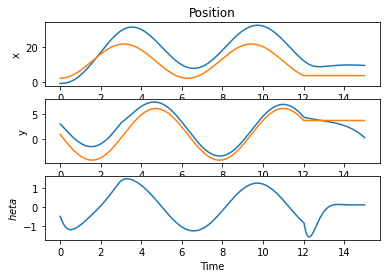

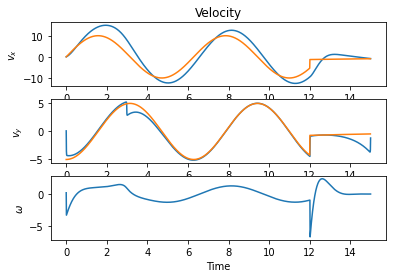

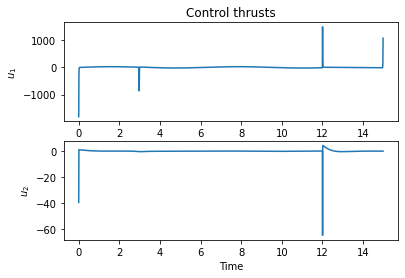

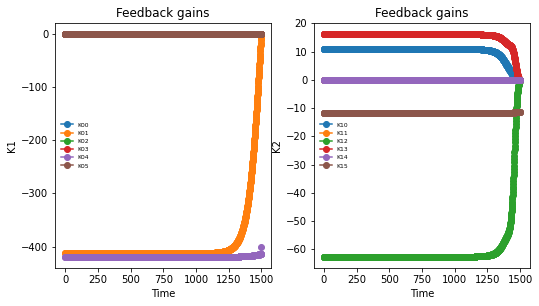

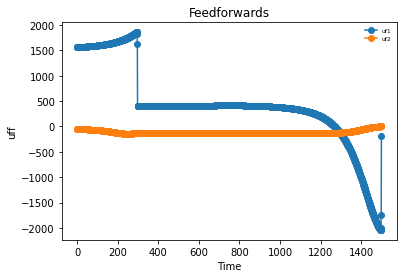

In [14]:
#track the 3rd path
P3,K3,p3,kf3 = solve_LQtracking(quadrotor.A, quadrotor.B, Q1, R1, z_des_3 ,horizon_length)

z_3,u_3 = quadrotor.LQ_simulate(z0_2, z_des_3, K3, kf3, horizon_length, feedforward = True)

LQTrackResults(z_3, u_3, z_des_3, K3, kf3, feedforward=True, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAFvWW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALwWWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0ALZS34I
Wx3uYA5RDRtbShrl92onXtCOF3soqrWRis0abaOtmJtHCBZqqydTegpXowDXBG6blu81O3T5l9d+
t9O2cBKqBU1OrA9/nLczIryI4Xkh9t/671UsUkv9G+s9laailM/nccMfdqTbbtLyAfJN+G4+cnw6
viWuoEqy1uNTNEtH6uXKh6NhACcSpOpVT8IPFqwO2docz4DyPmMCzOQr8g42ZiCjkR8o46RL3NGd
+4HEkfQW43/4q/zv845PAlrbH++FMwjRcA6IZySLzYWaagDi9X1fZpDvS8gn0pq4k1Wy/UZASdwi
PrGR5wXrjcKI2IgczrWBQAZra0H039n2jmwxZIfk7bsFDpZxMNCT4XFubko0W85zJQOvGQlKCaaO
TrXwdhhpAi/Clgk8dQ7Vb8Hgz/j+ZGezpQP8kWWIS6Dk2/7DmUQ7gTgYhfIUEqlteYVviwQwWJ13
ej9ez4scaw1ByIF7Oigf3fHIWQcntUelPHGDPtqAweJY/1NzLTzcxhgSFN4j01p66zdueNR32Amu
lLhHxj+SB1SpFBPsA1aYES6OZ8SJHOCdu31eWaw5YgW22RaQarUTKT2hpWQl53MDKt9dc63zcx+b
fIHWKmmgk8EM//v/Dy2DEcsLVuhC0XgUPYprJnyMR1xiWOwDR3GWmqGz4r4oE/qhBgZLVLvksuKb
MwT6exk06qdWR2eFmI/5/v+Hb8KMAAADAc72Bnb/Zr4du9WYQPUKjxDnL24HrHMhmp0EZgX5KljQ
7IInDjpJMuH5qKvQH8CMj1BIZo5/+IGH+YbZVTiS5/pUtwjjs+I9snVFy/4JqNhp/R5FF9e3bueq
H6VXkpLuwpW6IVWfRXUbyDzVNt4IzkCazUQN5zaAwtyACZ1aoMKF5q3WyZxn3emjfy20u3CXHdFi
T7kDOOKfPgVHt7HubmPo//64AZM1+dh2eqHm661WW4yY5V9JnRmlokrMCcfy1Ic+mZeZr9sMK0qe
O54UCNrk93x27+8DwTb81k5gcCXCGq7Vu8ex7se2JK1tfZAb/DaqsUM9/ZyfMUc4YRgm9HgJMZz8
R1yjM4pc3yPIU90rSIxYREIXawMwQ6nOipYkKUFnMn6O4OP0Dwc3zZxpRJ/ccdSeuxGa3VubmvVG
vhawqRYFrIKH1J0WvGTX1h/UZOLvad1nMchf4ZBKdjCUhN/IRlaouQtnOY0KmCO5Y3xwP983YMay
shQngTXNJrIaZi5/P3WWYRnJ55HDzx4tkv/TvD4Xb1Vfi0qW5OLDj/Lv3QSK+gEKBf4dcilYmdwO
c7JNM11ogAAA4eEvuJ//9y4Qxz48M1s0keK35udYJoXWEK3N7oMCE0ZxOK3B+ifx00K0HZcbINpc
AANqQ9UqlAlXuXj89Ah47vS8xDbdoN5VKSjPeGuZUbGDWZhqCPp7lofWlit86shFOdZvYPb2W4zg
PuSA6MNbaAs079nVmucWnOPWEa//64OIJiAz65A+EOrGtSJg2W+1+hIZyOaIMDOc8jOJNa4nZAoG
OPnkZD4J7ccFEHAacimfGF0bY/4KYDMoVK5GK4N6khqLH6SrL4DuJ5hn/HRiAY4G2xluyYZdK04Y
uti03ru5WUFnU55awwm0q2dTJfm8vFFt1twbNLgBf9lZd3OobSTpJigAb7n3Jqjmxlg7UtZjuIye
uF6lX2pi0PVWu1pFZhGBtJjfWfidqD94Wd8CdMQ1NbJJvi1x6YBunHPoYSdEb6MiSOedFnSo4a9n
NQ1qtEFo2dFpSP6xas1Lng11qmgEDj568IDQOh3LWGrWUr2NT9NTbvzkk+aOPUKbWoa+cjpDa1cP
4YjxnAATx3wrkd8W0jz3iB7NSBjgjBtaJzkv/TAFJarZJwHnIVg5T+1h2OGHT4Kei1V4j3AkyIBB
cgSMd4+6G2UV3XosjvHuigAAAwCKAGr1/bPdN7ISq49DhmZ0Fek7DL9f72OcmeNM/y1IAe3eFZSK
hGtF3ChMwMkeN12OVY31qSpa61/LauQYGtO0ti6tfx/c2Q9q5ErdxifHoiHyq9+INPW83Blyc6C1
bCw3eMaGFVyejAHwzSD5uKrXeROx/C4jpU2OMEIcSgSATxMhX6N1PfHSofT2EZQ5L4qXlrpQBvSZ
hNIGdx/8FBUZVBgD8/8MB1VfpBEWGL0DkH/wdAeiC0F59pl6Kc0ZR0QQxg+AL7/80AENTzQCaWpM
1doerAZvtkEqjcsFyKgGwdUfyrlCyG6VBUky9wRHtE4KcoebKdnlBWFsLJgYWIepuUdlUxE7OLr6
NLxVU3zPf1nztDBwHEFOoZjYomu8rY/zUfLHAiIibScvQRvmnSLRkQPbpvglhdlnWS5ertLtALL8
bNLx83GAB5KqLtKtrGDeiYmwH7noCiEd+hPKO/UtiiUzkk/tdWajKCCCAm47AB5Po3wNH27THAoU
NkQmc36cDzOiBKczwX78UAmzGqUq3Ea+81Ij+xFiuk1Uj0s/7WvPUKa+ydMcHqqdoK9WAoOwtoUO
n/tEN+wW1onFXaog+HtI936aqrvBnTLwoX7pai4UYVa81AVVp66uv8PmwCWZl3UuOXwVCR4FXee0
YdB3swxkJeS8xwgRmhrm1g9XBG1aaDJBeJSPCA81hBnQKgJQF80PWU9948eNCHKcbNfmhkm/+crW
/J+Ds5xc3DtJAqNbVJyBP/2jE6mq6OpuLxgLySmV7DjLZJDC/nYMa6P8biulsKq/3biAqGiZlXQ5
vBz4qFq4xITjpFbllhi5LckWC5Caq4RRPFepOVPWocngPeeKlrgBApAu5TIgP/C1nzKsOEl75S/o
Tg+SNdCmbEOWBpF1qSftq

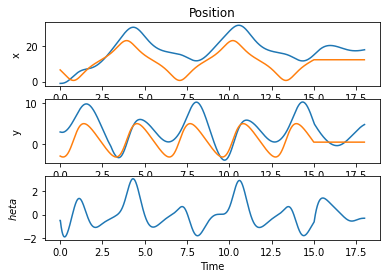

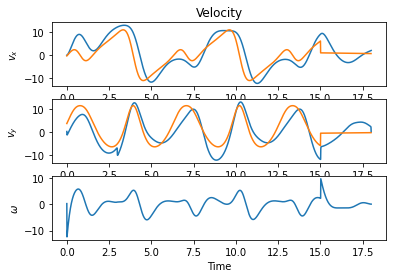

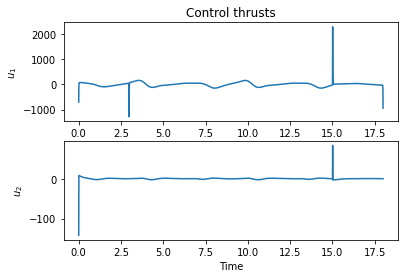

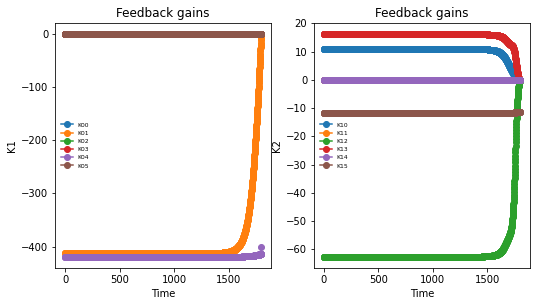

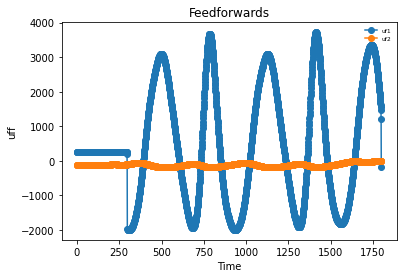

In [15]:
#track the 4th path
horizon_length = 1800
P4,K4,p4,kf4 = solve_LQtracking(quadrotor.A, quadrotor.B, Q1, R1, z_des_4 ,horizon_length2)

z_4,u_4 = quadrotor.LQ_simulate(z0_2, z_des_4, K4, kf4, horizon_length2, feedforward = True)

LQTrackResults(z_4, u_4, z_des_4, K4, kf4, feedforward=True, animate=True)